# AML - Assignment 1
## Paarth Iyer  -  MCS202218

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# perm for the scrambling part
fixed_perm = torch.randperm(784)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Functions that will be used later on


In [4]:
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

#### Function to visualize predicted labels and the probability distribution of the output

In [5]:
def visualize_preds(
    image_batch,        
    label_batch,        
    log_pred_prob_batch,
    figsize=(4, 3),
    num_imgs=10,        
    num_labels=10,
    start_at=0,
    class_names=None,
    label_size=10
):
    """Visualize given images along with the probabilities of the labels rpedicted by the model

    Args:
        image_batch (torch.Tensor): A batch of images which are to be visualized
        label_batch (torch.Tensor): Corresponding labels to the images
        log_pred_prob_batch (torch.Tensor): Predicted log-prob of the images by the moodel
        figsize (tuple, optional): Defaults to (4, 3).
        num_imgs (int, optional): Number of images to show. Defaults to 10.
        num_labels (int, optional): Number of classes for the data. Defaults to 10.
        start_at (int, optional): Where to start reading for the images i nthe large batch. Defaults to 0.
        class_names (_type_, optional): List of class names for the data. Defaults to None.
    """
    for i in range(start_at, start_at + num_imgs):
        plt.figure(figsize=figsize)
        
        # images and labels for ith index
        img = image_batch[i]
        real_label = label_batch[i].item()
        log_pred_prob = log_pred_prob_batch[i]
        # predicted label
        pred_label = log_pred_prob.max(0, keepdim=True)[1].squeeze().item()
        # Output of the network are log-probabilities, need to take exponential for probabilities
        pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()

        # plotting the image
        plt.subplot(1, 2, 1)
        plt.imshow(img.numpy().squeeze(), cmap="gray")
        plt.axis("off")
        
        
        # set label to classname if class names are given
        if class_names == None:
            label = real_label if pred_label == None else (pred_label, real_label)
        else:
            label = (
                class_names[real_label]
                if pred_label == None
                else f"pred : {class_names[pred_label]}\nreal : {class_names[real_label]}"
            )
        plt.title(label, fontsize=10)


        # plotting the hbar for label probabilities
        ax = plt.subplot(1, 2, 2)
        ax.barh(np.arange(num_labels), pred_prob)
        ax.set_aspect(0.14)
        ax.set_yticks(np.arange(num_labels))
        ax.set_yticklabels(class_names if class_names is not None else np.arange(num_labels), fontsize=label_size)
        ax.set_title("Prediction Probability", fontsize=10)
        ax.set_xlim(0, 1.1)

#### A helper function to plot scrambled images alongside normal images

In [6]:
def scramble_plt(
    image_batch: torch.Tensor,
    label_batch: torch.Tensor,
    perm,
    figsize=(8, 8),
    num_images=6,
    start_at = 0,
    cmap="gray",
    class_names=None
):
    """Plots image and its scrambled version

    Args:
        image_batch (torch.Tensor): A batch of images which are to be visualized
        label_batch (torch.Tensor): Corresponding labels to the images
        perm (list[int]): Permutation for scrambling
        figsize (tuple, optional):  Defaults to (8, 8).
        num_images (int, optional): Number of images to plot. Defaults to 6.
        start_at(int, optional): Starting index in the batch. Defaults to 0.
        cmap (str, optional): cmap for imshow. Defaults to "gray".
        class_names (list[str], optional): classnames of the labels
    """
    plt.figure(figsize=figsize)

    for i in range(start_at, start_at+num_images):
        image = image_batch[i]
        
        #scramble image
        image_perm = image.view(-1, 28 * 28).clone()
        image_perm = image_perm[:, perm]
        image_perm = image_perm.view(-1, 1, 28, 28)

        label = label_batch[i].item()
        plt.subplot(num_images//3 + 1, 4, 2 * i + 1)
        
        plt.imshow(image.squeeze().numpy(), cmap=cmap)
        plt.axis("off")
        plt.title(label if class_names is None else class_names[label])
        plt.subplot(num_images//3 + 1, 4, 2 * i + 2)
        plt.imshow(image_perm.squeeze().numpy(), cmap=cmap)
        plt.axis("off")
        plt.title(label if class_names is None else class_names[label])

#### Function for training 1 epoch, this also takes a permutation which, if provided, permutes the image before training

In [7]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    epoch: int,
    optimizer: torch.optim.Optimizer,
    perm = None
):
    """trains the model for 1 epoch

    Arguments:
        model (nn.Module): Model to train
        train_loader (DataLoader): Dataloader for the training set
        epoch (int): Epoch number
        optimizer (torch.optim.Optimizer): Optimizer for training
        perm (list[int], optional): Permutaion, which is provided if model is to be trained with scrambled images. Defaults to None.

    Returns:
        list: returns losses built up during this epoch
    """
   
    model.train() # set the model to training mode
    losses_log = []# log the losses per iteration

    pbar = tqdm(total=len(train_loader), desc=f"Training Epoch {epoch}")
    # pbar initializes a progress bar
    for idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        
        #if a permutation is given, permute the pixels in the image according to that permutation
        if perm is not None:
            data = data.view(-1, 28 * 28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
        
        optimizer.zero_grad()  # zero gradients in the optimizer
        output = model(data)   # take the model output
        
        loss = F.cross_entropy(output, target)  # calculate loss
        
        # backpropogation step
        loss.backward()
        optimizer.step()
        
        # append loss to the log and update the progress bar
        losses_log.append(loss.detach().item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.detach().item(), "avg_loss": sum(losses_log)/(idx+1)})

    pbar.close()    # close the progressbar
    return losses_log


#### Function to test the model on the test set

In [8]:
def test(model: nn.Module, 
         test_loader: DataLoader, 
         perm = None,
         accuracy_list: list|None = None):
    """test model on the test set

    Args:
        model (nn.Module): Model to test
        test_loader (DataLoader): Datalaoder for test set
        perm (list[int], optional): Permutaion, which is provided if model is to be trained with scrambled images. Defaults to None.
        accuracy_list (list): if provided, appends an external list with the test accuracy for this round
    """
    model.eval()  # set model to evaluation mode

    test_loss = 0
    correct = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        #if a permutation is given, permute the pixels in the image according to that permutation
        if perm is not None:
            data = data.view(-1, 28 * 28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

        output = model(data)  # take the model output
        # add the loss of this batch, taken in sum mode, to the total loss
        test_loss += F.cross_entropy(output, target, reduction="sum").item()  

        pred = output.data.max(1, keepdim=True)[1]   # take the predicted label, ie, label with highest prob
        
        # how many predictions are correct
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    # average the test loss over the whole dataset
    test_loss /= len(test_loader.dataset)
    # accuracy of the model
    accuracy = 100.0 * correct / len(test_loader.dataset)
    
    if accuracy_list is not None:
        accuracy_list.append(accuracy)

    print(f"Test set: Avg. loss : {test_loss:.2f}\tAccuracy : {correct}/{len(test_loader.dataset)} ({accuracy:.1f}%)")

#### A training loop which trains and tests the model. 

In [9]:
def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    perm = None,
    num_epoch: int = 10,
    starting_epoch: int = 0,
    test_interval: int = 1,
):
    """Training loop for the model which trains the model and tests it every 'test_interval' steps

    Args:
        model (nn.Module): Model to train and test
        train_loader (DataLoader): Dataloader for training set
        test_loader (DataLoader): Dataloader for test set
        optimizer (torch.optim.Optimizer): Optimizer for training
        perm (list[int], optional): Permutaion, which is provided if model is to be trained with scrambled images. Defaults to None.
        num_epoch (int, optional):  Number of epochs to train for. Defaults to 10.
        starting_epoch (int, optional): Epoch to start at. Defaults to 0.
        test_interval (int, optional): Interval of epochs between each test. Defaults to 1.

    Returns:
        list[int] : List of accuracy in each testing period
    """
    accuracy_list = []
    print("Starting training from epoch {}".format(starting_epoch))

    for epoch in range(starting_epoch, starting_epoch + num_epoch):
        train(model, train_loader, epoch, optimizer, perm = perm)

        if epoch % test_interval == 0:
            test(model, test_loader,perm = perm, accuracy_list=accuracy_list)

    print(f"Training for {epoch} epochs completed!")

    return accuracy_list

### Functions related to adveserial attacks

#### This function performs the FGSM attack on the model with the given epsilon and logs some of the successful examples

In [10]:
def fgsm_test(model: nn.Module, 
              test_loader: DataLoader, 
              epsilon: int, 
              save_examples: int = 10):
    """Perform the FGSM attack on the model with given epsilon

    Args:
        model (nn.Module): Model to attack
        test_loader (DataLoader): Dataset to perform this atatck on
        epsilon (int): Multiplication factor for the noise
        save_examples (int, optional): Number of examples to save. Defaults to 10.

    Returns:
        (int, list[(int, ndarray, int, ndarray)]): returns the final accuracy, 
                                                    and a list of (actual label, actual image, false label, altered image)
    """
    correct = 0
    adv_examples = []
    
    model.to(device)
    model.eval()
    
    # initialize the progress bar
    pbar = tqdm(desc = "FGSM attack", total=len(test_loader.dataset))
    
    # test_loader can have any batch size
    for (data, target) in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True   #require grad on the data to perform backprop on it
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        model.zero_grad() # reset gradients on the model
        loss.backward()   # backprop on the loss
        
        # perform the following loop for each image in the batch
        for i in range(len(target)):
            
            # check initial prediction of the model on the ith image 
            first_pred = output[i].max(0, keepdim=True)[1].squeeze()

            # if the pred doesnot match the actual label, move on to the next one
            if first_pred.item() != target[i].item():
                pbar.update(1)
                continue
            
            # get the gradient of the loss on the ith image
            data_grad = data.grad.data[i]
            sign_data_grad = data_grad.sign()   # get the sign of the grad
            perturbed_data = torch.clamp(data[i] + epsilon*sign_data_grad, 0, 1)  # clamp it to 0,1
            
            # get the output and prediction of the model on the altered image
            perturbed_output = model(perturbed_data.view(-1,1,28,28))
            petrurbed_pred = perturbed_output.max(1, keepdim=True)[1].squeeze()
            
            # if new label is incorrect, save the example if list is not full.
            # otherwise, increase the number of correct by 1
            if petrurbed_pred.item() != target[i].item():  
                if len(adv_examples) < save_examples:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()  
                    real_im = data[i].squeeze().detach().cpu().numpy()
                    # save the correct label, real image, wrong label, corresponding altered image
                    adv_examples.append((first_pred.item(), real_im, petrurbed_pred.item(), adv_ex))
            else:
                correct += 1
            
            # update the progress bar
            pbar.update(1)
            pbar.set_postfix_str(f"Correct : {correct}")
        
        
    final_accuracy = correct/float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\t Test accuracy = {correct}/{len(test_loader.dataset)} = {final_accuracy}")
    
    return final_accuracy, adv_examples

#### the following function generates a plot for the adv examples found in the above process

In [11]:
def show_fgsm_example(epsilon, adv_example, figsize=(6,9), class_names=None):
    """Generates a plot for the adv examples found in the above process.
       adv_examples has the format : (real_label/pred, real_image, incorrect_label, altered image)

    Args:
        epsilon (float): Multiplication factor for the noise
        adv_example : see above
        figsize (tuple, optional):  Defaults to (6,9).
        labels (list[str], optional): Class names for the given data. Defaults to None.
    """
    real_pred, real_image, alt_pred, alt_image = adv_example
    noise = alt_image - real_image
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=figsize, ncols=4)
    
    ax1.imshow(real_image,cmap='gray')
    ax1.axis('off')
    if class_names != None:
        ax1.set_title(class_names[real_pred])
    else:
        ax1.set_title(real_pred)
        
    ax2.imshow(alt_image,cmap='gray')
    ax2.axis('off')
    if class_names != None:
        ax2.set_title(class_names[alt_pred])
    else:
        ax2.set_title(alt_pred)
        
    ax3.imshow(1-noise,cmap='gray',vmin=0., vmax=1.)
    ax3.axis('off')
    ax3.set_title(f"Noise * {epsilon}")


    ax4.imshow(noise/epsilon,cmap='gray')
    ax4.axis('off')
    ax4.set_title("Noise")

#### other helper functions

In [12]:
# plots the epsilon vs accs graph 
def plot_eps_vs_acc(epsilons, adv_accs, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.plot(epsilons, np.array(adv_accs), "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .25, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

## Fashion MNIST

In [13]:
# set input as image dims and output as number of classes
input_size = 28 * 28
output_size = 10

# set class names
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [14]:
# loading the train and test datasets into datalaoder
fashion_train = DataLoader(
    datasets.FashionMNIST(
        root="../data", train=True, download=True, transform=ToTensor()
    ),
    batch_size=64,
    shuffle=True,
    num_workers = 10
)


fashion_test = DataLoader(
    datasets.FashionMNIST(
        root="../data", train=False, download=True, transform=ToTensor()
    ),
    batch_size=1000,
    shuffle=True,
    num_workers = 10
)

### Fully Connected Network for FasnionMNIST

The network used here consists of 4 hidden layers, of dims 50, 50, 50 and 30 respectively. The activation function is ReLU for each layer, and it has a logsoftmax at the end.

In [15]:
class FashionFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FashionFNN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.network(x)

In [16]:
print("Training on ", device)

# initializing the network
fashion_fnn = FashionFNN(input_size, output_size)
fashion_fnn.to(device)

# Using the Adam optimizer with 0.004 learning rate
optimizer = optim.Adam(fashion_fnn.parameters(), lr=0.004)
print(f"Number of parameters: {get_n_params(fashion_fnn)}")

Training on  cuda:0
Number of parameters: 46190


In [17]:
# Training for 16 epochs, testing after 3 epochs
train_loop(fashion_fnn, fashion_train, fashion_test, optimizer, num_epoch=16, test_interval=3)

Starting training from epoch 0


Training Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 0: 100%|██████████| 938/938 [00:06<00:00, 150.33it/s, loss=0.246, avg_loss=0.614]


Test set: Avg. loss : 0.53	Accuracy : 8102/10000 (81.0%)


Training Epoch 3: 100%|██████████| 938/938 [00:05<00:00, 170.05it/s, loss=0.291, avg_loss=0.36] 


Test set: Avg. loss : 0.39	Accuracy : 8573/10000 (85.7%)


Training Epoch 6: 100%|██████████| 938/938 [00:05<00:00, 167.57it/s, loss=0.328, avg_loss=0.326]


Test set: Avg. loss : 0.40	Accuracy : 8584/10000 (85.8%)


Training Epoch 9: 100%|██████████| 938/938 [00:05<00:00, 174.15it/s, loss=0.157, avg_loss=0.307]


Test set: Avg. loss : 0.38	Accuracy : 8660/10000 (86.6%)


Training Epoch 12: 100%|██████████| 938/938 [00:05<00:00, 170.46it/s, loss=0.338, avg_loss=0.288] 


Test set: Avg. loss : 0.36	Accuracy : 8683/10000 (86.8%)


Training Epoch 15: 100%|██████████| 938/938 [00:05<00:00, 170.06it/s, loss=0.0842, avg_loss=0.277]


Test set: Avg. loss : 0.39	Accuracy : 8740/10000 (87.4%)
Training for 15 epochs completed!


[81.02, 85.73, 85.84, 86.6, 86.83, 87.4]

Training the network gives around 87.4% error on the test set

Looking at some results

In [18]:
fashion_fnn.to("cpu").eval()
image_batch, label_batch = next(iter(fashion_test))

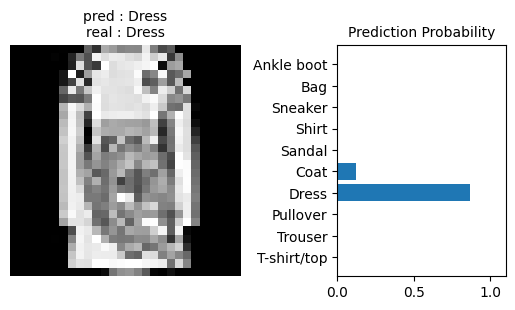

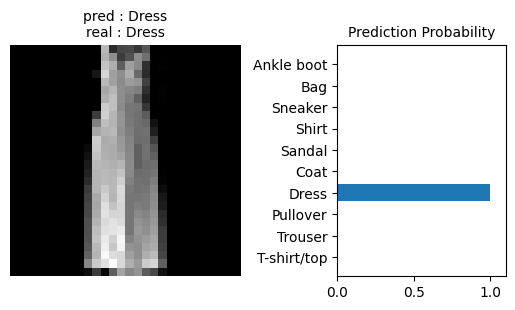

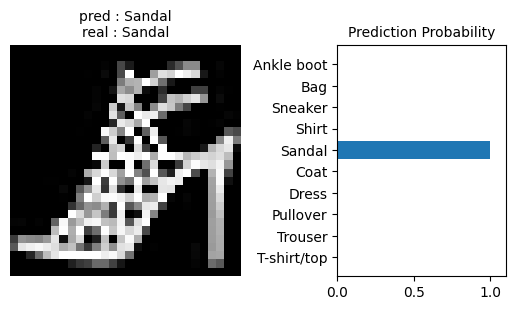

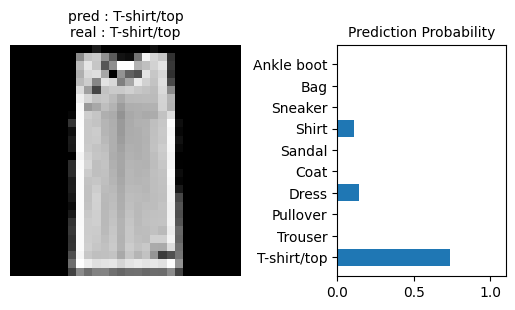

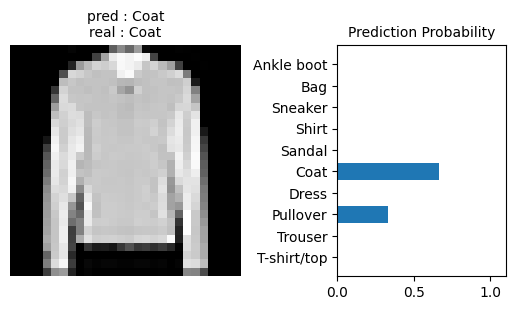

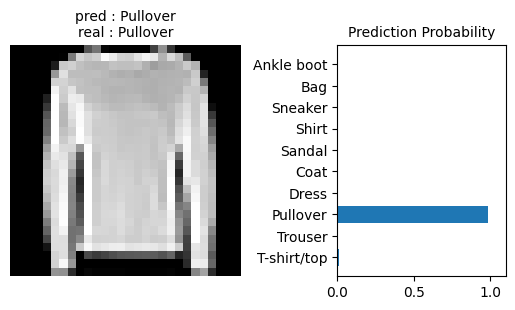

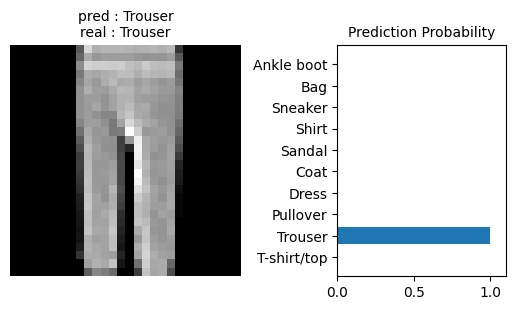

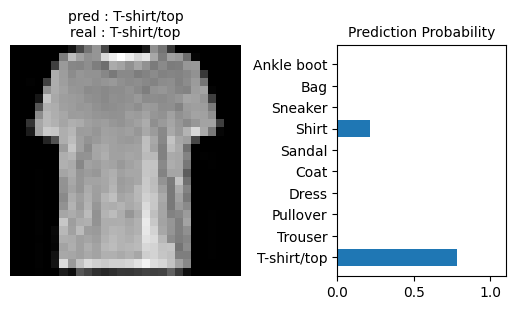

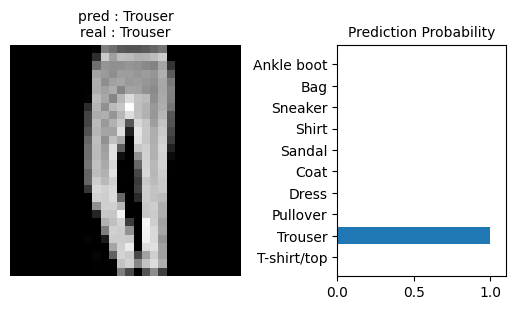

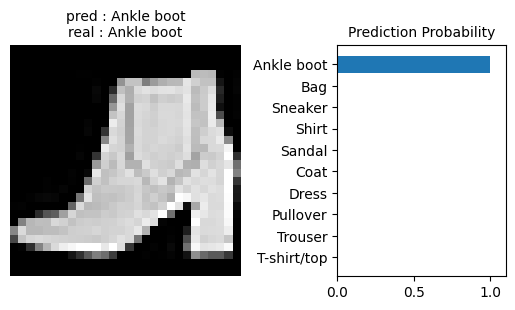

In [19]:
log_pred_prob_batch = fashion_fnn(image_batch)
visualize_preds(
    image_batch, label_batch, log_pred_prob_batch, class_names=class_names, start_at=15, figsize=(7,3)
)

#### Effect of scrambling on the FNN 

To test this, a permutatioin will be fixed and the training with be performed using that permutation of pixels

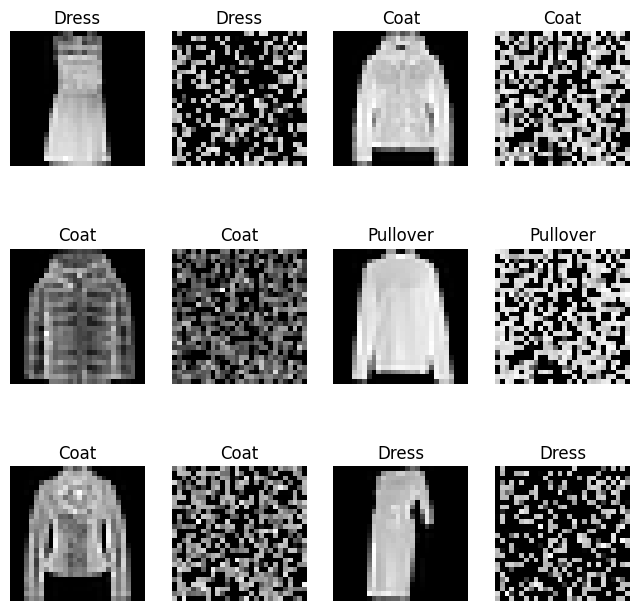

In [20]:


image_batch, label_batch = next(iter(fashion_test))
scramble_plt(image_batch, label_batch, fixed_perm, class_names=class_names)

Training the network on scrambled images

In [21]:
print("Training on ", device)
# initializer a network with the same parameters as the normal case
fashion_scrambled_fnn = FashionFNN(input_size, output_size)
fashion_scrambled_fnn.to(device)

optimizer = optim.Adam(fashion_scrambled_fnn.parameters(), lr=0.004)
print(f"Number of parameters: {get_n_params(fashion_scrambled_fnn)}")

Training on  cuda:0
Number of parameters: 46190


In [22]:
# Training for 16 epochs, testing after 3 epochs. Also passing the fixed_perm through this function
train_loop(fashion_scrambled_fnn, fashion_train, fashion_test, optimizer, perm=fixed_perm, num_epoch=16, test_interval=3)

Starting training from epoch 0


Training Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 0: 100%|██████████| 938/938 [00:05<00:00, 174.24it/s, loss=0.226, avg_loss=0.598]


Test set: Avg. loss : 0.47	Accuracy : 8304/10000 (83.0%)


Training Epoch 3: 100%|██████████| 938/938 [00:05<00:00, 163.20it/s, loss=0.239, avg_loss=0.356] 


Test set: Avg. loss : 0.40	Accuracy : 8586/10000 (85.9%)


Training Epoch 6: 100%|██████████| 938/938 [00:05<00:00, 166.07it/s, loss=0.355, avg_loss=0.32]  


Test set: Avg. loss : 0.39	Accuracy : 8673/10000 (86.7%)


Training Epoch 9: 100%|██████████| 938/938 [00:05<00:00, 170.96it/s, loss=0.463, avg_loss=0.296] 


Test set: Avg. loss : 0.39	Accuracy : 8695/10000 (87.0%)


Training Epoch 12: 100%|██████████| 938/938 [00:05<00:00, 169.57it/s, loss=0.442, avg_loss=0.284] 


Test set: Avg. loss : 0.38	Accuracy : 8701/10000 (87.0%)


Training Epoch 15: 100%|██████████| 938/938 [00:05<00:00, 158.46it/s, loss=0.369, avg_loss=0.273] 


Test set: Avg. loss : 0.38	Accuracy : 8681/10000 (86.8%)
Training for 15 epochs completed!


[83.04, 85.86, 86.73, 86.95, 87.01, 86.81]

Training the network on scrambled images also gives around 87% error. This is almost equal to the standard training set, which is to be expected as the network is fully connected, and local patterns are not weighted much.

Testing the model output by passing scrambled images

In [23]:
fashion_scrambled_fnn.to('cpu')

# get a batch of image and label, then scramble the images
image_batch, label_batch = next(iter(fashion_test))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)

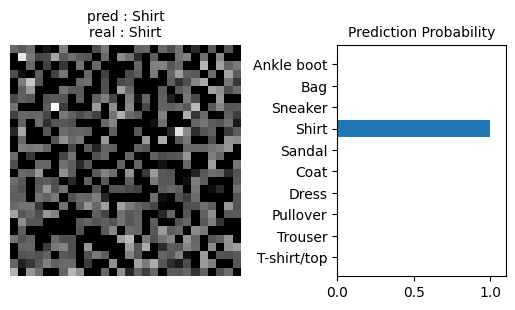

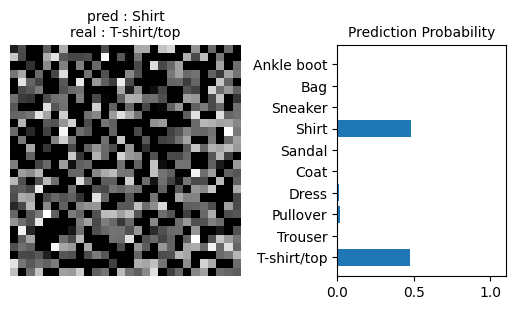

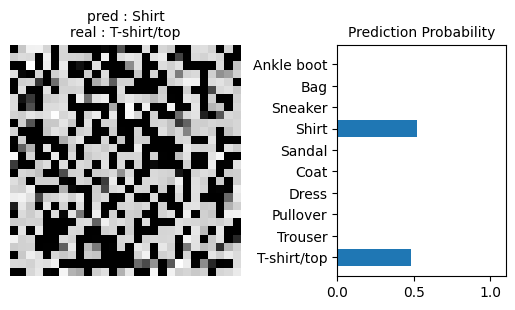

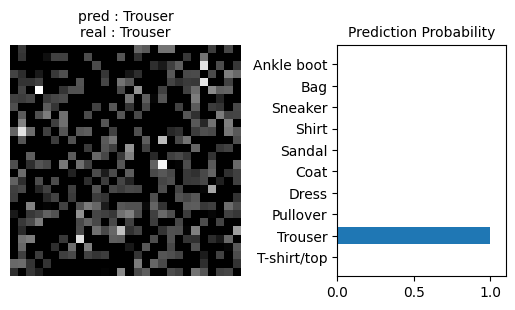

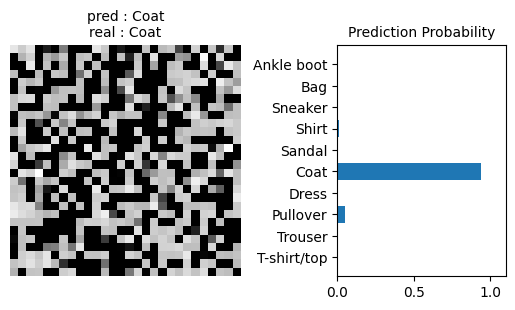

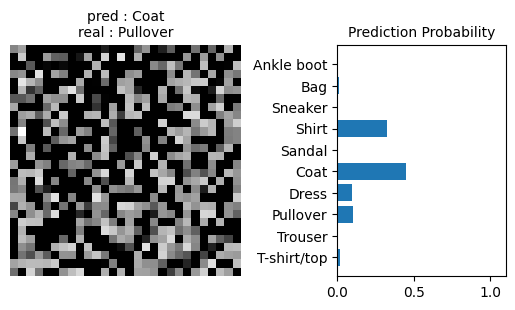

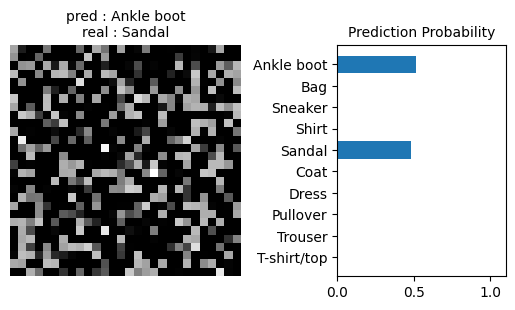

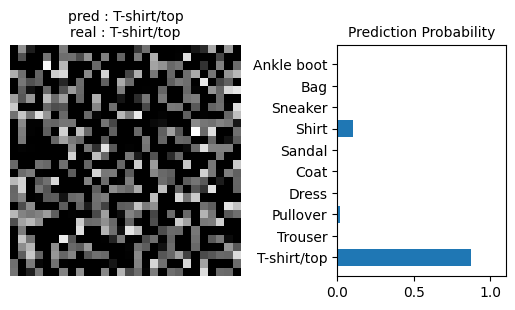

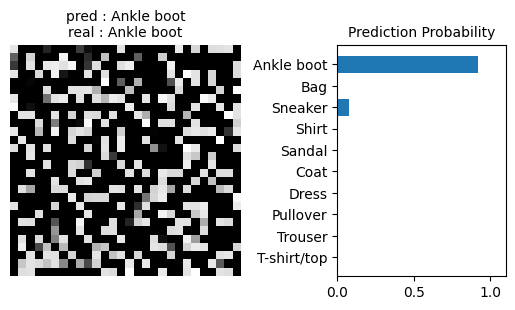

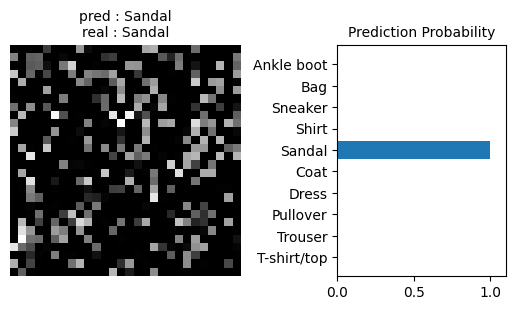

In [24]:
# get the log probs for the labels predicted by the scrambled model on the scrambled batch
log_pred_prob_batch = fashion_scrambled_fnn(image_batch_scramble)
visualize_preds(
    image_batch_scramble, label_batch, log_pred_prob_batch, class_names=class_names, start_at=10, figsize=(7,3)
)


#### Adversarial attack on FashionMNIST FNN using FGSM method
We will fix some values of epsilon and see the accuracy of the model after an FGSM attack with that epsilon is conducted on that model

In [25]:
epsilons = [0, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]

adv_examples = []  # store examples for eachepsilon
adv_accs = []      # store the accuracy for each epsilon

In [26]:
# run the attack for each epsilon
for eps in epsilons:
    acc, adv_exs = fgsm_test(fashion_fnn, fashion_test, eps)
    adv_examples.append(adv_exs)
    adv_accs.append(acc)

FGSM attack:   0%|          | 0/10000 [00:00<?, ?it/s]

FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 882.89it/s, Correct : 8740]


Epsilon: 0	 Test accuracy = 8740/10000 = 0.874


FGSM attack: 100%|██████████| 10000/10000 [00:10<00:00, 924.46it/s, Correct : 8643]


Epsilon: 0.001	 Test accuracy = 8643/10000 = 0.8643


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 877.48it/s, Correct : 8539]


Epsilon: 0.002	 Test accuracy = 8539/10000 = 0.8539


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 890.89it/s, Correct : 8348]


Epsilon: 0.004	 Test accuracy = 8348/10000 = 0.8348


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 873.35it/s, Correct : 7943]


Epsilon: 0.008	 Test accuracy = 7943/10000 = 0.7943


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 888.53it/s, Correct : 7690]


Epsilon: 0.01	 Test accuracy = 7690/10000 = 0.769


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 868.76it/s, Correct : 6531]


Epsilon: 0.02	 Test accuracy = 6531/10000 = 0.6531


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 860.95it/s, Correct : 4583]


Epsilon: 0.04	 Test accuracy = 4583/10000 = 0.4583


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 870.33it/s, Correct : 2251]


Epsilon: 0.08	 Test accuracy = 2251/10000 = 0.2251


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 887.14it/s, Correct : 1469]


Epsilon: 0.1	 Test accuracy = 1469/10000 = 0.1469


FGSM attack: 100%|██████████| 10000/10000 [00:11<00:00, 871.44it/s, Correct : 442]


Epsilon: 0.2	 Test accuracy = 442/10000 = 0.0442


The epsilon-accuracy graph 

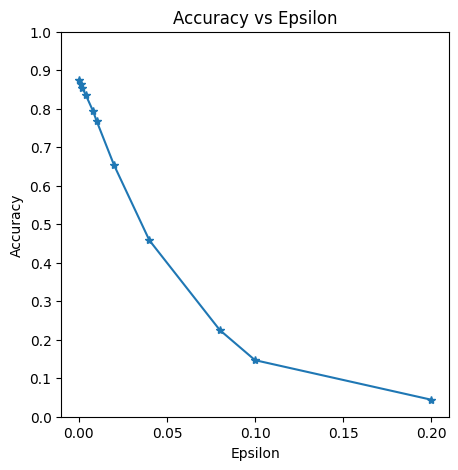

In [27]:
plot_eps_vs_acc(epsilons, adv_accs)

Using some value of epsilon between 0.07 to 0.1 seems to be the best considering the tradeoff between readability of the image and the performance of the FGSM attack

Some examples of successful misclassifications for each epsilon value

/tmp/ipykernel_24507/3767312654.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=figsize, ncols=4)


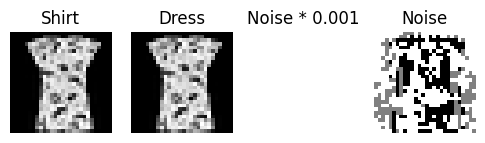

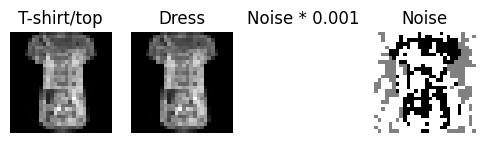

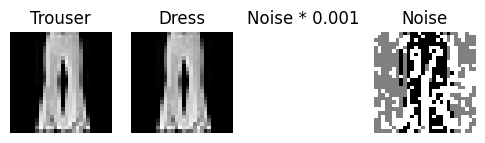

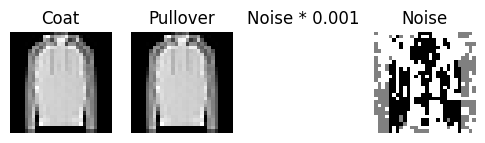

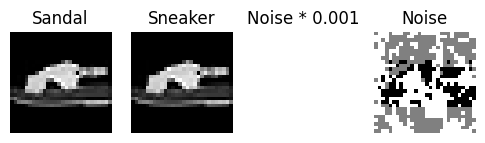

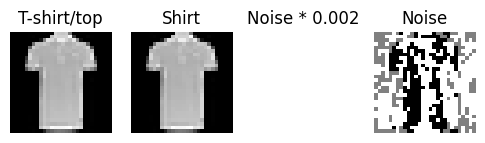

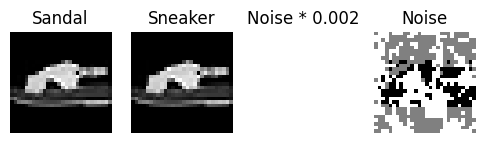

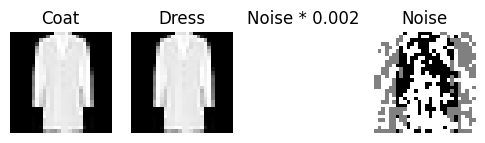

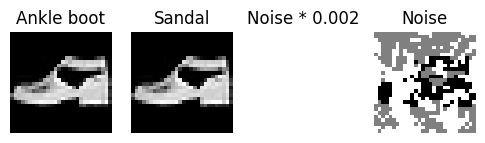

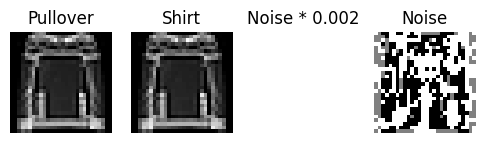

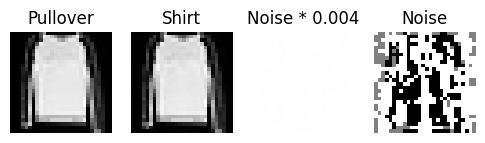

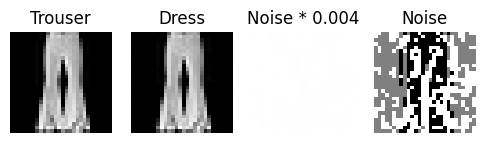

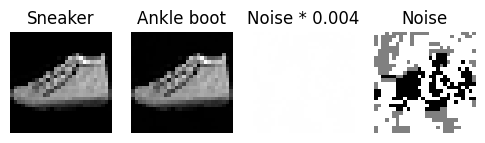

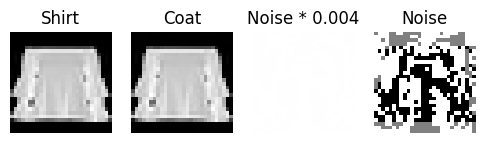

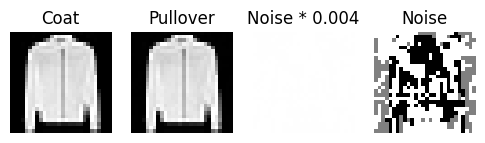

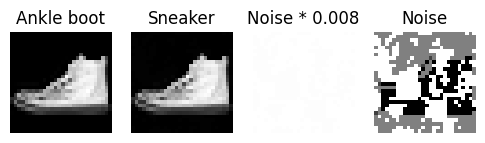

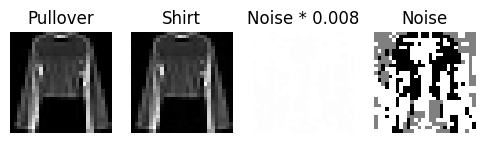

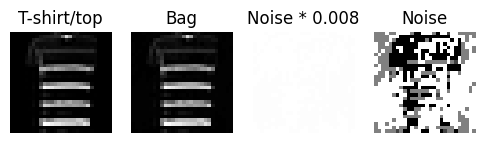

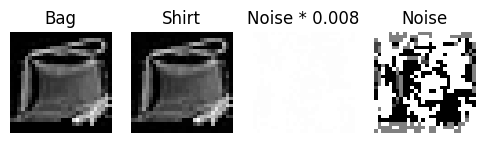

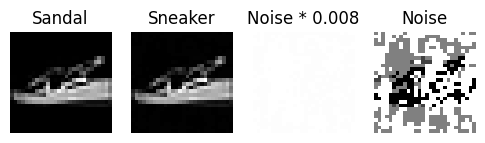

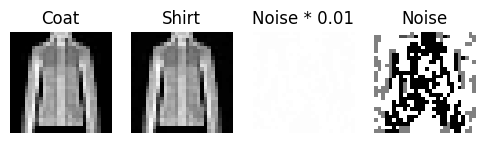

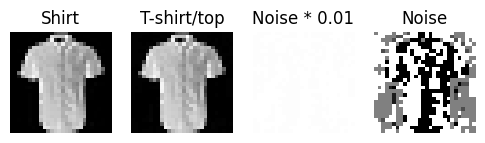

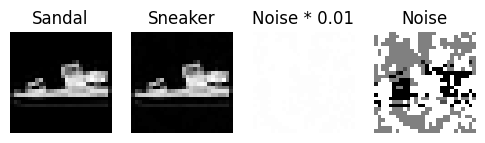

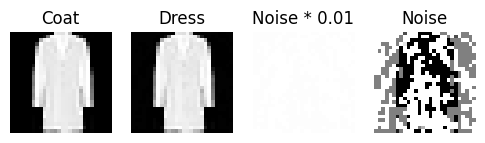

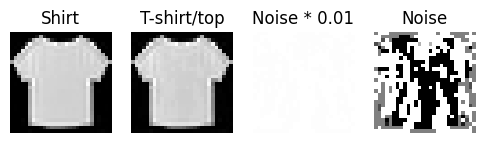

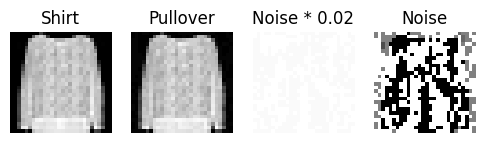

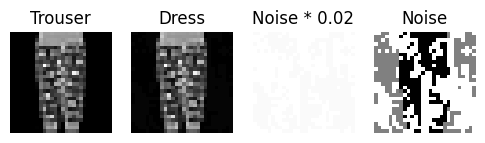

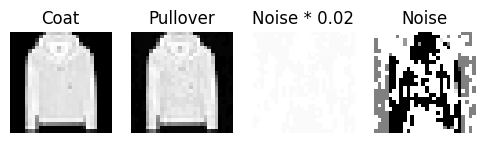

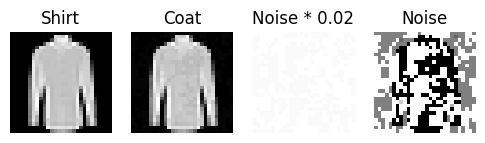

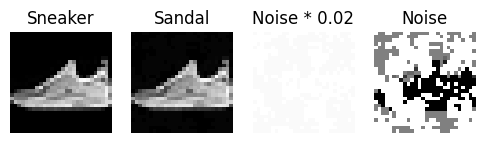

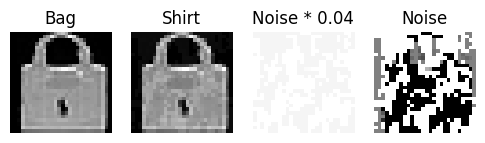

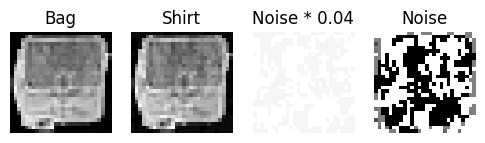

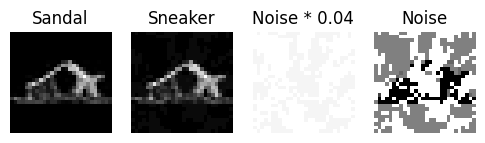

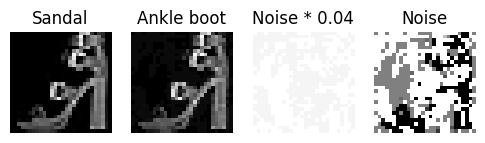

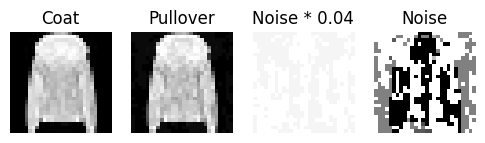

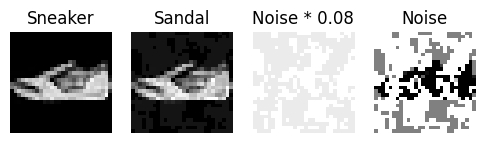

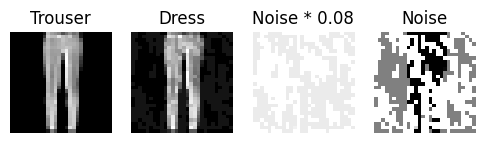

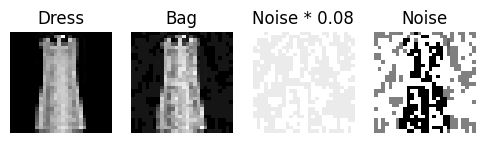

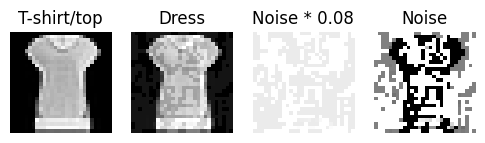

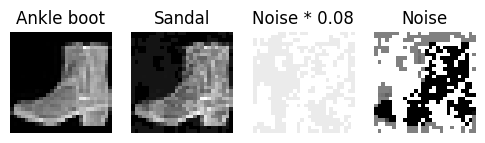

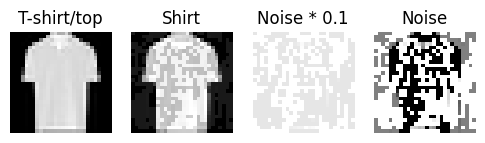

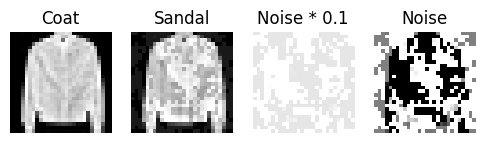

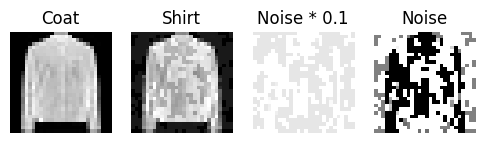

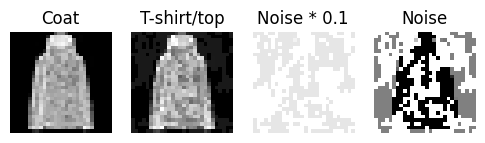

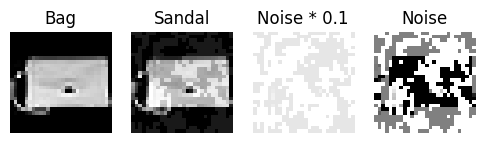

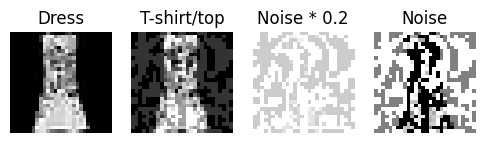

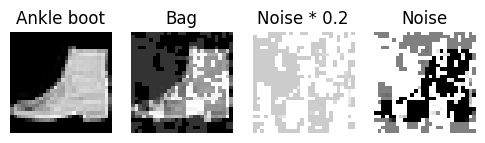

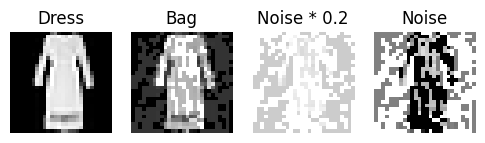

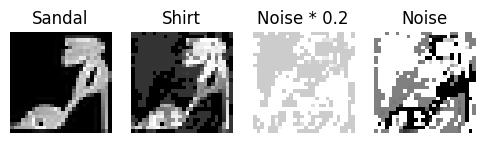

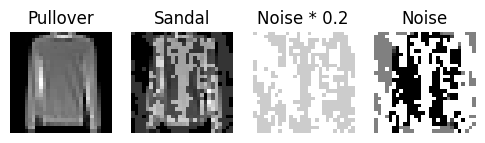

In [28]:
for i in range(len(epsilons)):
    for j in range(min(5, len(adv_examples[i]))): 
        show_fgsm_example(epsilons[i], adv_examples[i][j], class_names = class_names)

### Convolution Network for FasnionMNIST

The network used here consists of 3 convolution layer, kernel sizes 3, 5, 5 respectively. The first two conv layers are followed by relu and a 2x2 maxpool. This is followed by a flatten operation and then a fully connected network with one hidden layer with 200 neurons. At the end there is a logsoftmax 

In [29]:
class FashionCNN(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(FashionCNN, self).__init__()
        self.conv_netowrk = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
        )

        self.fc_network = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_netowrk(x)
        x = x.view(-1, 128*4*4)
        x = self.fc_network(x)
        return x

In [30]:
print("Training on ", device)

# initializing the network
fashion_cnn = FashionCNN(input_size, output_size)
fashion_cnn.to(device)

# Using the Adam optimizer with 0.004 learning rate
optimizer = optim.Adam(fashion_cnn.parameters(), lr=0.004)
print(f"Number of parameters: {get_n_params(fashion_cnn)}")

Training on  cuda:0
Number of parameters: 620234


In [31]:
# Training for 15 epochs, testing after 3 epochs
train_loop(fashion_cnn, fashion_train, fashion_test, optimizer, num_epoch=16, test_interval=3)

Starting training from epoch 0


Training Epoch 0: 100%|██████████| 938/938 [00:09<00:00, 101.41it/s, loss=0.148, avg_loss=0.416]


Test set: Avg. loss : 0.34	Accuracy : 8760/10000 (87.6%)


Training Epoch 3: 100%|██████████| 938/938 [00:06<00:00, 136.97it/s, loss=0.139, avg_loss=0.216] 


Test set: Avg. loss : 0.29	Accuracy : 8942/10000 (89.4%)


Training Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 124.34it/s, loss=0.184, avg_loss=0.171] 


Test set: Avg. loss : 0.25	Accuracy : 9164/10000 (91.6%)


Training Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 132.62it/s, loss=0.146, avg_loss=0.139] 


Test set: Avg. loss : 0.29	Accuracy : 9123/10000 (91.2%)


Training Epoch 12: 100%|██████████| 938/938 [00:07<00:00, 126.93it/s, loss=0.188, avg_loss=0.116]  


Test set: Avg. loss : 0.31	Accuracy : 9134/10000 (91.3%)


Training Epoch 15: 100%|██████████| 938/938 [00:07<00:00, 128.39it/s, loss=0.0455, avg_loss=0.0907] 


Test set: Avg. loss : 0.36	Accuracy : 9137/10000 (91.4%)
Training for 15 epochs completed!


[87.6, 89.42, 91.64, 91.23, 91.34, 91.37]

The CNN model seems to around 91% accuracy on the training set

Looking at some results

In [32]:
fashion_cnn.to("cpu").eval()
image_batch, label_batch = next(iter(fashion_test))

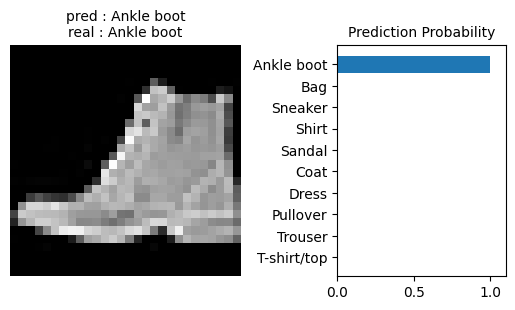

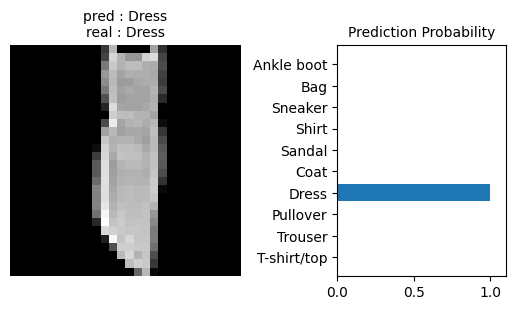

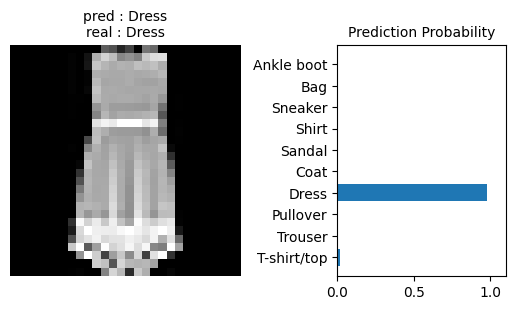

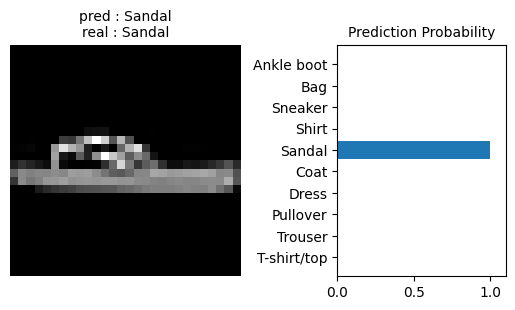

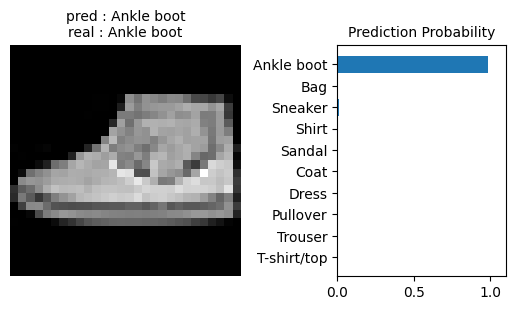

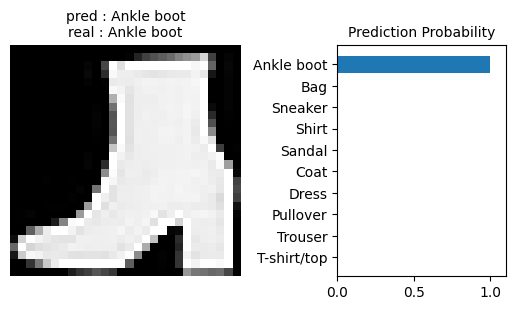

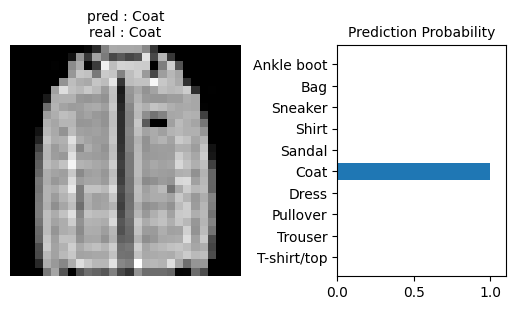

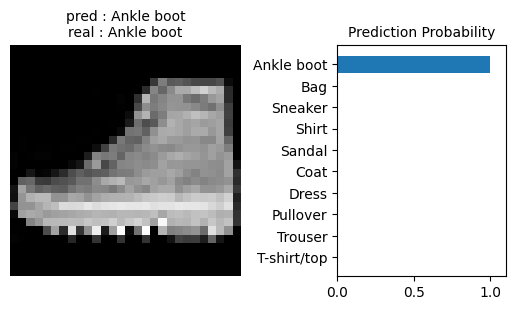

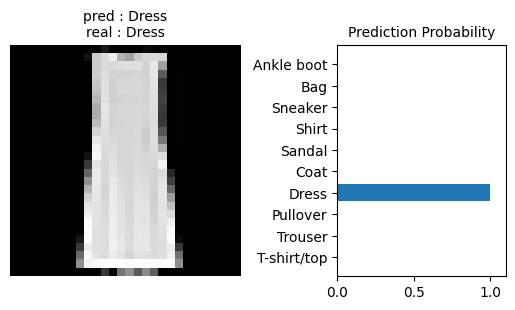

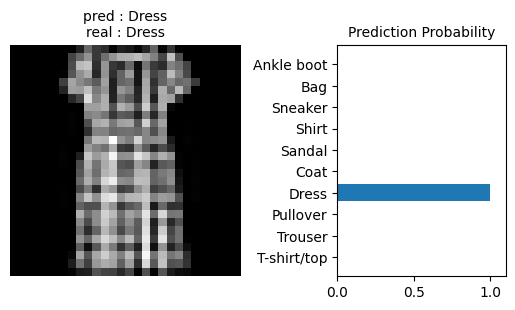

In [33]:
log_pred_prob_batch = fashion_cnn(image_batch)
visualize_preds(
    image_batch, label_batch, log_pred_prob_batch, class_names=class_names, start_at=15, figsize=(7, 3)
)

#### Effect of scrambling on the CNN 

To test this, a permutatioin will be fixed and the training with be performed using that permutation of pixels

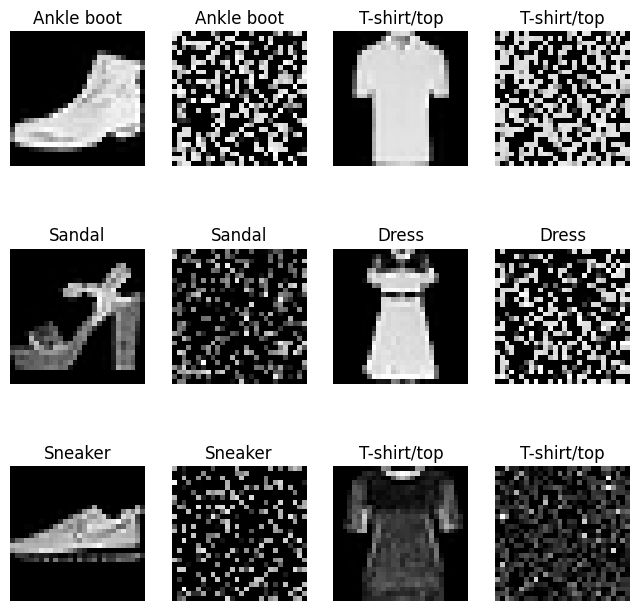

In [34]:


image_batch, label_batch = next(iter(fashion_test))
scramble_plt(image_batch, label_batch, fixed_perm, class_names=class_names)

Training the network on scrambled images

In [35]:
print("Training on ", device)
# initializer a network with the same parameters as the normal case
fashion_scrambled_cnn = FashionCNN(input_size, output_size)
fashion_scrambled_cnn.to(device)

optimizer = optim.Adam(fashion_scrambled_cnn.parameters(), lr=0.004)
print("Number of parameters: {}".format(get_n_params(fashion_scrambled_cnn)))

Training on  cuda:0
Number of parameters: 620234


In [36]:
# Training for 15 epochs, testing after 3 epochs. Also passing the fixed_perm through this function
train_loop(fashion_scrambled_cnn, fashion_train, fashion_test, optimizer, perm=fixed_perm, num_epoch=16, test_interval=3)

Starting training from epoch 0


Training Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 0: 100%|██████████| 938/938 [00:06<00:00, 145.64it/s, loss=0.498, avg_loss=0.498]


Test set: Avg. loss : 0.41	Accuracy : 8490/10000 (84.9%)


Training Epoch 3: 100%|██████████| 938/938 [00:07<00:00, 127.09it/s, loss=0.183, avg_loss=0.273] 


Test set: Avg. loss : 0.35	Accuracy : 8733/10000 (87.3%)


Training Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 127.54it/s, loss=0.194, avg_loss=0.22]  


Test set: Avg. loss : 0.38	Accuracy : 8758/10000 (87.6%)


Training Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 129.66it/s, loss=0.161, avg_loss=0.177] 


Test set: Avg. loss : 0.43	Accuracy : 8720/10000 (87.2%)


Training Epoch 12: 100%|██████████| 938/938 [00:07<00:00, 124.09it/s, loss=0.0769, avg_loss=0.146]


Test set: Avg. loss : 0.44	Accuracy : 8778/10000 (87.8%)


Training Epoch 15: 100%|██████████| 938/938 [00:07<00:00, 125.26it/s, loss=0.171, avg_loss=0.123] 


Test set: Avg. loss : 0.47	Accuracy : 8789/10000 (87.9%)
Training for 15 epochs completed!


[84.9, 87.33, 87.58, 87.2, 87.78, 87.89]

For the scrambled images, the CNN only achieves an accuracy of aroung 88%, which is a 3% loss over the standard CNN

Testing the model output by passing scrambled images

In [38]:
fashion_scrambled_cnn.to('cpu')

# get a batch of image and label, then scramble the images
image_batch, label_batch = next(iter(fashion_test))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)

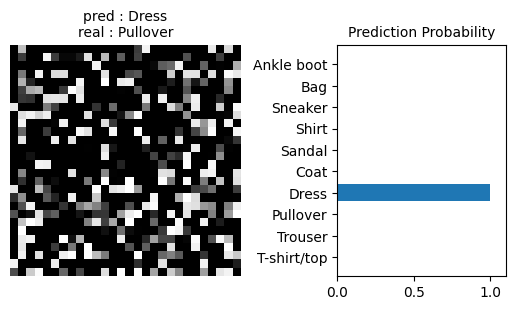

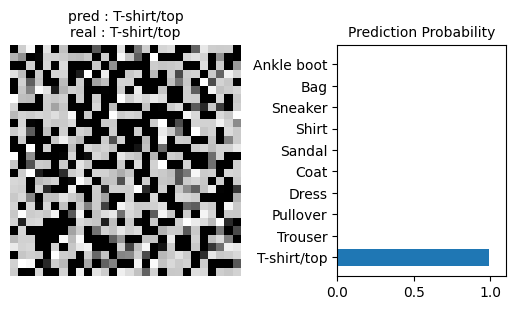

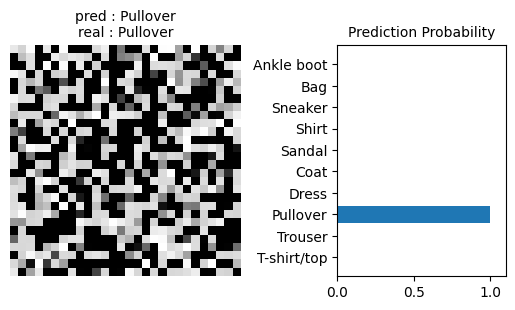

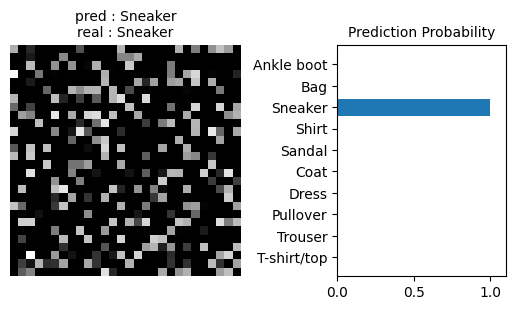

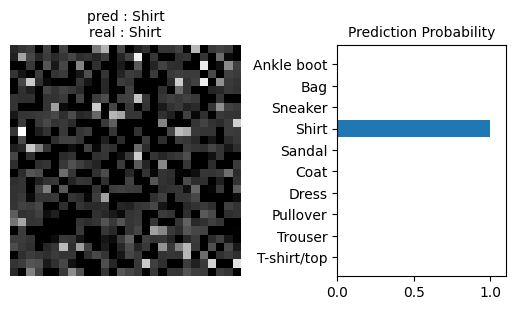

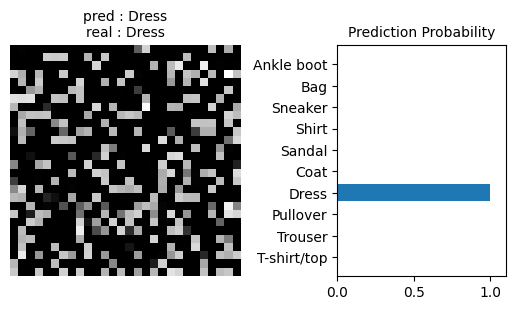

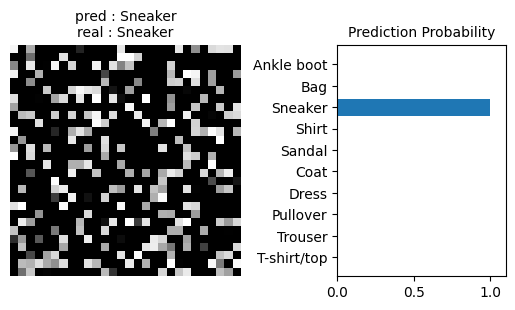

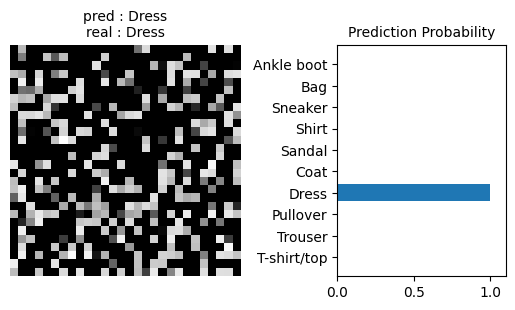

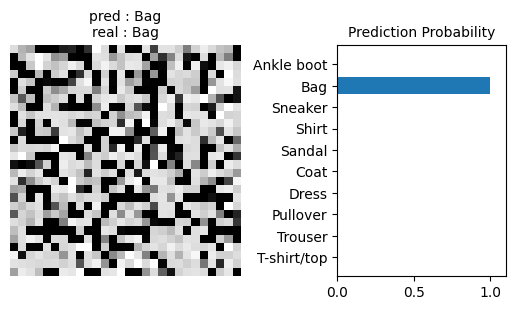

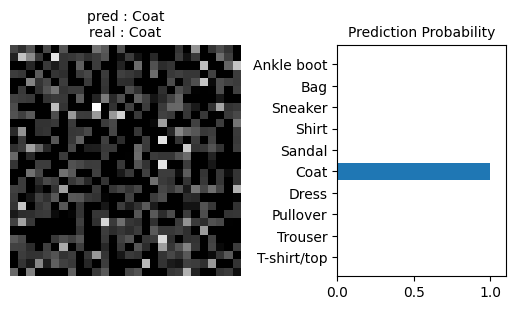

In [39]:
# get the log probs for the labels predicted by the scrambled model on the scrambled batch
log_pred_prob_batch = fashion_scrambled_cnn(image_batch_scramble)
visualize_preds(
    image_batch_scramble, label_batch, log_pred_prob_batch, class_names=class_names, start_at=10, figsize=(7,3)
)

#### Adversarial attack on FashionMNIST CNN using FGSM method
We will fix some values of epsilon and see the accuracy of the model after an FGSM attack with that epsilon is conducted on that model

In [40]:
epsilons = [0, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]

adv_examples = []  # store examples for eachepsilon
adv_accs = []      # store the accuracy for each epsilon

In [41]:
# run the attack for each epsilon
for eps in epsilons:
    acc, adv_exs = fgsm_test(fashion_cnn, fashion_test, eps)
    adv_examples.append(adv_exs)
    adv_accs.append(acc)

FGSM attack:   0%|          | 0/10000 [00:00<?, ?it/s]

FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 624.36it/s, Correct : 9137]


Epsilon: 0	 Test accuracy = 9137/10000 = 0.9137


FGSM attack: 100%|██████████| 10000/10000 [00:15<00:00, 626.05it/s, Correct : 8909]


Epsilon: 0.001	 Test accuracy = 8909/10000 = 0.8909


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 618.10it/s, Correct : 8680]


Epsilon: 0.002	 Test accuracy = 8680/10000 = 0.868


FGSM attack: 100%|██████████| 10000/10000 [00:15<00:00, 628.08it/s, Correct : 8220]


Epsilon: 0.004	 Test accuracy = 8220/10000 = 0.822


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 619.18it/s, Correct : 7256]


Epsilon: 0.008	 Test accuracy = 7256/10000 = 0.7256


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 593.89it/s, Correct : 6826]


Epsilon: 0.01	 Test accuracy = 6826/10000 = 0.6826


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 613.35it/s, Correct : 5118]


Epsilon: 0.02	 Test accuracy = 5118/10000 = 0.5118


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 610.75it/s, Correct : 3511]


Epsilon: 0.04	 Test accuracy = 3511/10000 = 0.3511


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 615.34it/s, Correct : 2204]


Epsilon: 0.08	 Test accuracy = 2204/10000 = 0.2204


FGSM attack: 100%|██████████| 10000/10000 [00:15<00:00, 641.50it/s, Correct : 1865]


Epsilon: 0.1	 Test accuracy = 1865/10000 = 0.1865


FGSM attack: 100%|██████████| 10000/10000 [00:16<00:00, 611.87it/s, Correct : 1287]


Epsilon: 0.2	 Test accuracy = 1287/10000 = 0.1287


The epsilon-accuracy graph 

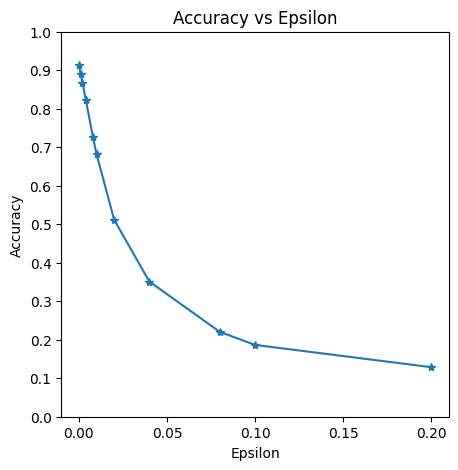

In [42]:
plot_eps_vs_acc(epsilons, adv_accs)

Some examples of successful misclassifications for each epsilon value

/tmp/ipykernel_24507/3767312654.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=figsize, ncols=4)


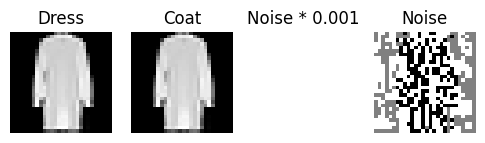

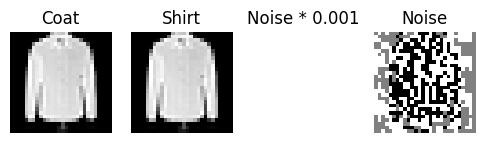

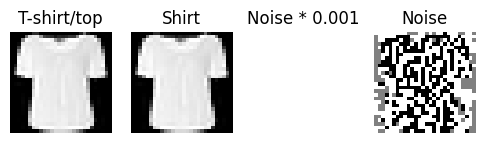

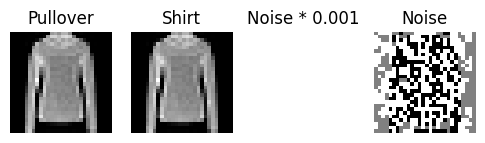

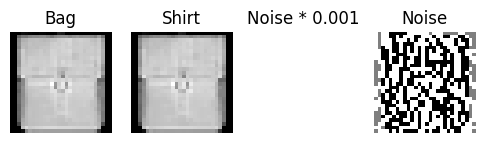

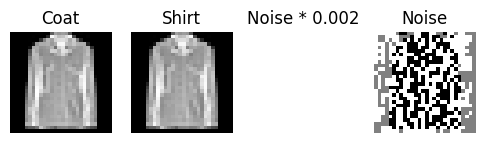

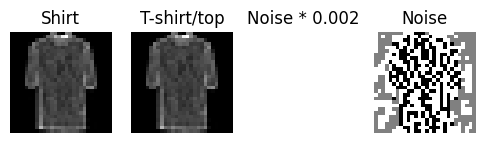

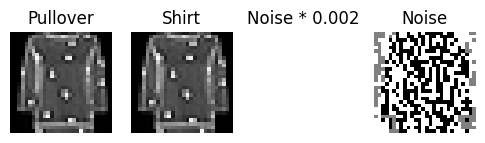

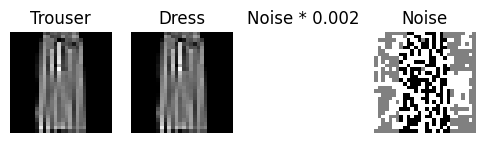

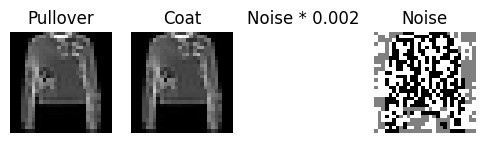

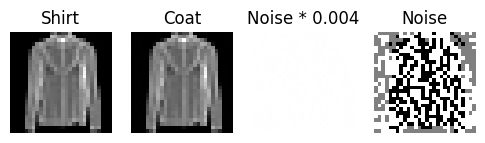

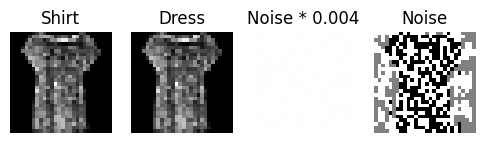

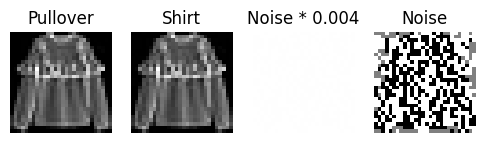

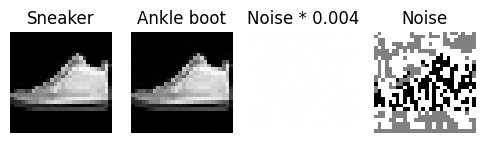

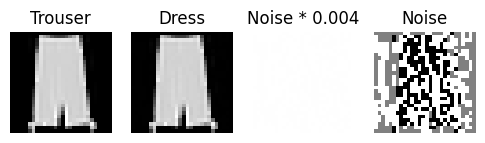

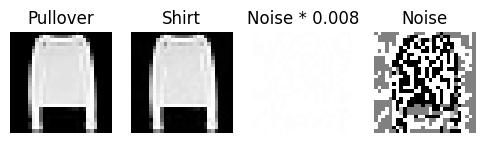

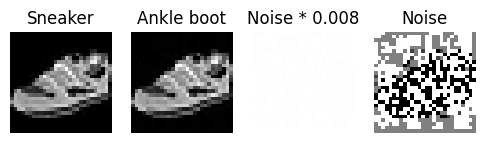

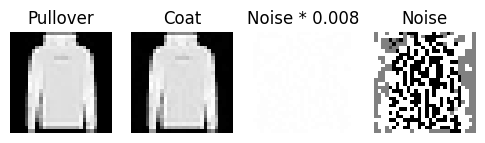

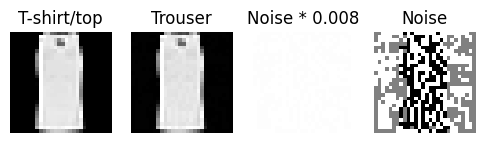

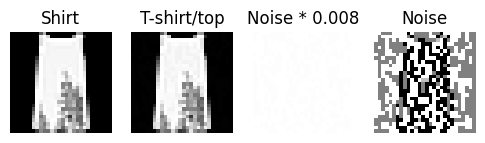

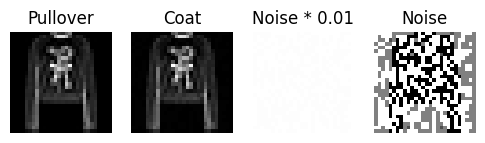

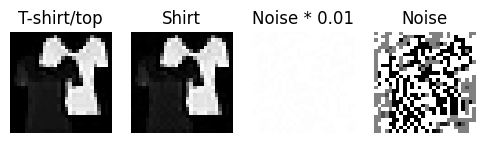

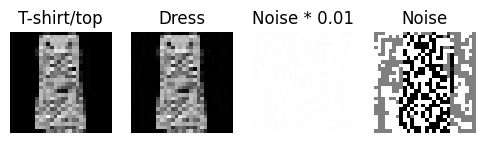

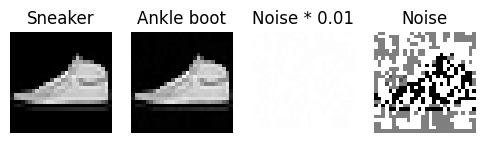

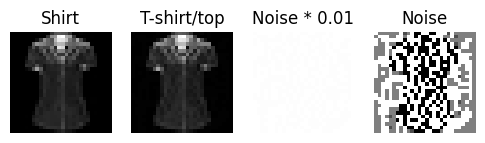

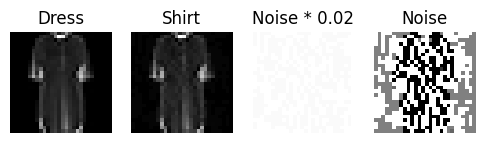

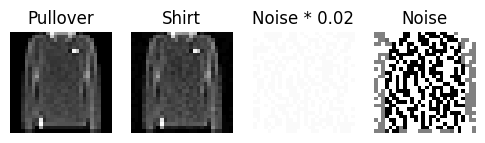

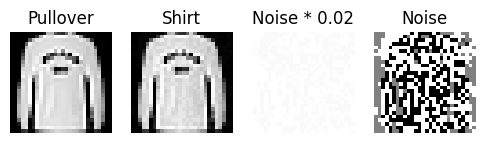

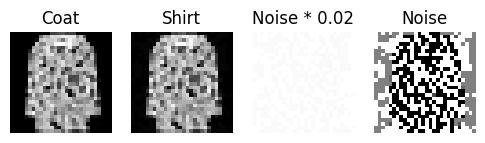

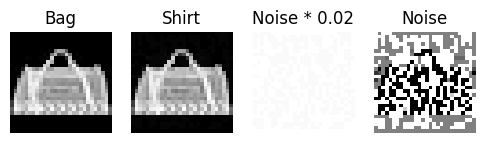

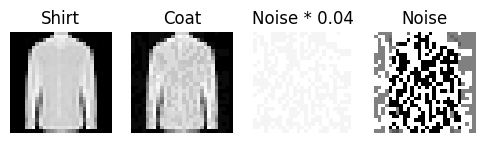

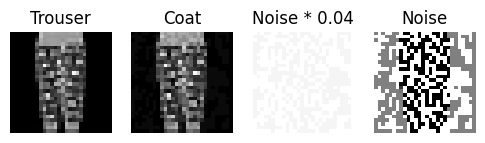

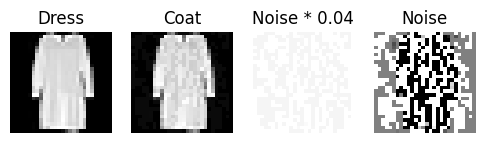

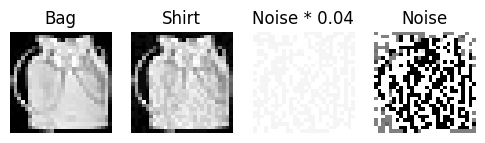

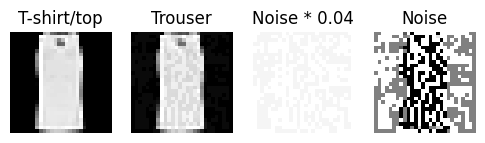

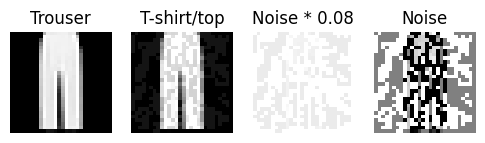

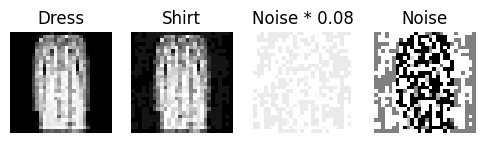

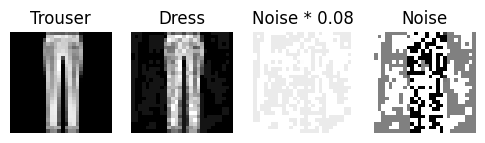

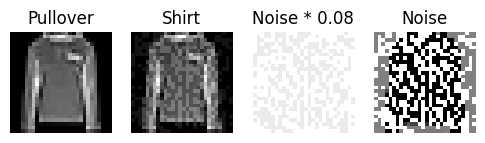

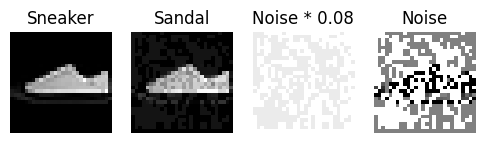

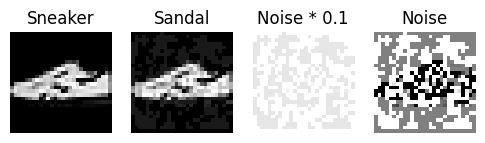

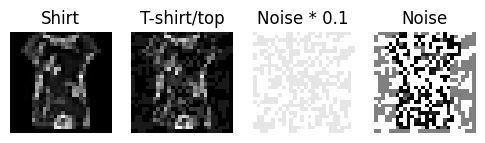

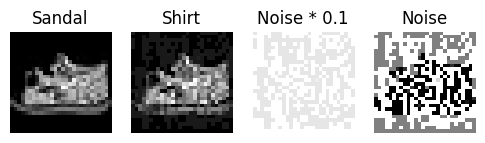

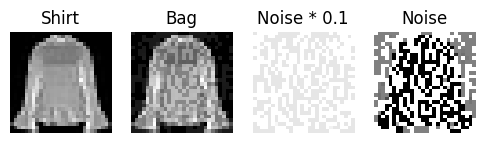

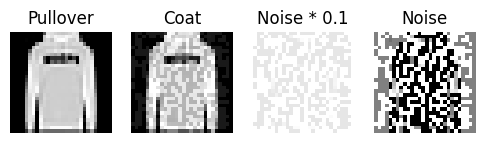

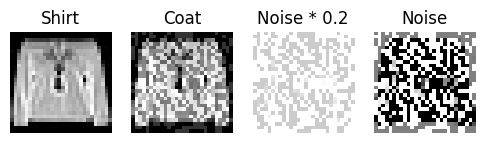

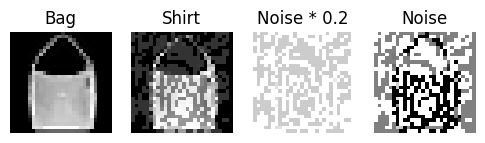

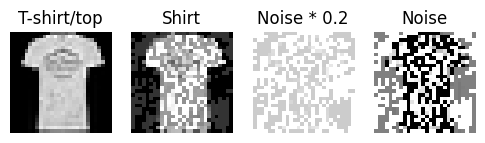

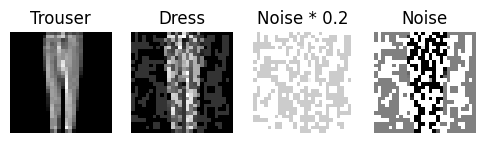

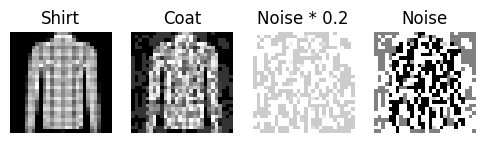

In [43]:
for i in range(len(epsilons)):
    for j in range(min(5, len(adv_examples[i]))): 
        show_fgsm_example(epsilons[i], adv_examples[i][j], class_names = class_names)

## Sign MNIST

In [44]:
# set input as image dims and output as number of classes
input_size = 28 * 28
output_size = 26

# set class names
class_names = ["A","B","C","D" ,"E" ,"F" ,"G" ,"H" ,"I" ,"J","K" ,"L" ,"M" ,"N" ,"O" ,"P" ,"Q" ,"R" ,"S" ,"T" ,"U" ,"V" ,"W" ,"X" ,"Y" ,"Z"]

In [45]:
class SignMNIST(torch.utils.data.Dataset):
    def __init__(self,csv):
        self.csv=pd.read_csv(csv)
        # print(self.csv['image_names'][:5])
        text="pixel"
        self.images=torch.zeros((self.csv.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.csv[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.csv['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,1,28,28)
        self.images /= 255.
        
    def __getitem__(self,index):
        return self.images[index],self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [46]:
# loading the train and test datasets into datalaoder
signMNIST_train = SignMNIST("../data/SignMNIST/sign_mnist_train/sign_mnist_train.csv")
signMNIST_test = SignMNIST("../data/SignMNIST/sign_mnist_test/sign_mnist_test.csv")

sign_train = DataLoader(
    signMNIST_train,
    batch_size=64,
    shuffle=True,
    num_workers = 10
)


sign_test = DataLoader(
    signMNIST_test,
    batch_size=1000,
    shuffle=True,
    num_workers = 10
)

### Fully Connected Network for SignMNIST

The network used here consists of 4 hidden layers, of dims 200, 200, 200, 100 respectively. The activation function is ReLU for each layer, and it has a logsoftmax at the end.

In [47]:
class SignFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SignFNN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.network(x)

In [48]:
print("Training on ", device)

# initializing the network
sign_fnn = SignFNN(input_size, output_size)
sign_fnn.to(device)

# Using the Adam optimizer with 0.001 learning rate
optimizer = optim.Adam(sign_fnn.parameters(), lr=0.001)
print(f"Number of parameters: {get_n_params(sign_fnn)}")

Training on  cuda:0
Number of parameters: 260126


In [49]:
# Training for 15 epochs, testing after 3 epochs
train_loop(sign_fnn, sign_train, sign_test, optimizer, num_epoch=51, test_interval=5)

Starting training from epoch 0


Training Epoch 0: 100%|██████████| 429/429 [00:02<00:00, 156.11it/s, loss=1.93, avg_loss=2.54]


Test set: Avg. loss : 2.20	Accuracy : 1957/7172 (27.3%)


Training Epoch 5: 100%|██████████| 429/429 [00:02<00:00, 149.28it/s, loss=0.452, avg_loss=0.514]


Test set: Avg. loss : 1.67	Accuracy : 4074/7172 (56.8%)


Training Epoch 10: 100%|██████████| 429/429 [00:02<00:00, 153.52it/s, loss=0.171, avg_loss=0.105]   


Test set: Avg. loss : 1.64	Accuracy : 4979/7172 (69.4%)


Training Epoch 15: 100%|██████████| 429/429 [00:02<00:00, 154.35it/s, loss=0.0138, avg_loss=0.013]   


Test set: Avg. loss : 1.97	Accuracy : 5231/7172 (72.9%)


Training Epoch 20: 100%|██████████| 429/429 [00:02<00:00, 153.27it/s, loss=0.123, avg_loss=0.148]    


Test set: Avg. loss : 1.59	Accuracy : 5066/7172 (70.6%)


Training Epoch 25: 100%|██████████| 429/429 [00:02<00:00, 163.22it/s, loss=0.111, avg_loss=0.135]      


Test set: Avg. loss : 1.60	Accuracy : 4874/7172 (68.0%)


Training Epoch 30: 100%|██████████| 429/429 [00:02<00:00, 147.83it/s, loss=0.0029, avg_loss=0.0757]  


Test set: Avg. loss : 1.57	Accuracy : 5470/7172 (76.3%)


Training Epoch 35: 100%|██████████| 429/429 [00:02<00:00, 150.63it/s, loss=0.000468, avg_loss=0.000701]


Test set: Avg. loss : 1.95	Accuracy : 5297/7172 (73.9%)


Training Epoch 40: 100%|██████████| 429/429 [00:02<00:00, 145.84it/s, loss=0.000158, avg_loss=0.000147]


Test set: Avg. loss : 2.20	Accuracy : 5314/7172 (74.1%)


Training Epoch 45: 100%|██████████| 429/429 [00:02<00:00, 148.18it/s, loss=0.000377, avg_loss=0.000548]


Test set: Avg. loss : 2.05	Accuracy : 5296/7172 (73.8%)


Training Epoch 50: 100%|██████████| 429/429 [00:02<00:00, 145.14it/s, loss=0.000171, avg_loss=0.000507]


Test set: Avg. loss : 1.86	Accuracy : 5332/7172 (74.3%)
Training for 50 epochs completed!


[27.286670384829893,
 56.8042387060792,
 69.42275515895147,
 72.93641940881204,
 70.63580591187953,
 67.95872838817624,
 76.26882320133853,
 73.85666480758505,
 74.09369771332962,
 73.84272169548242,
 74.3446737311768]

The accuracy seems to hover around 74%

Looking at some results

In [50]:
sign_fnn.to("cpu").eval()
image_batch, label_batch = next(iter(sign_test))

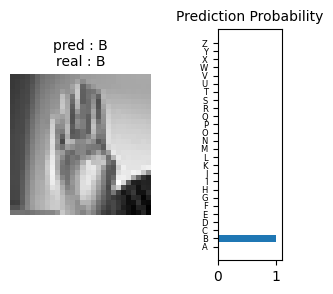

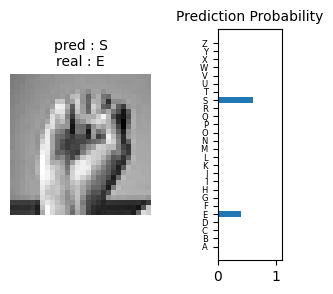

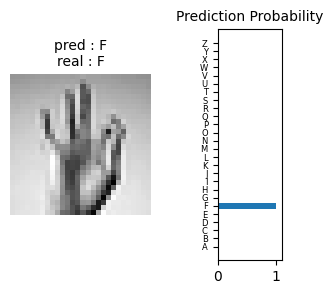

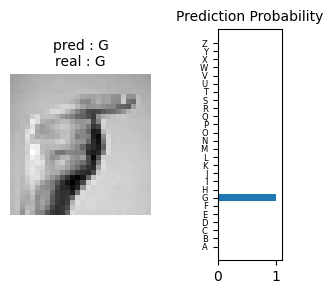

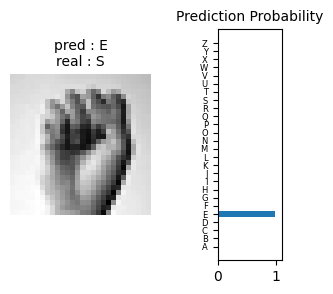

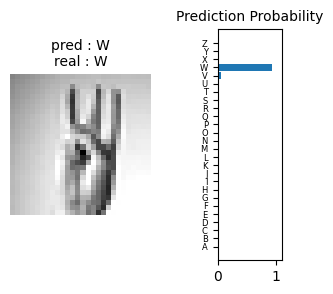

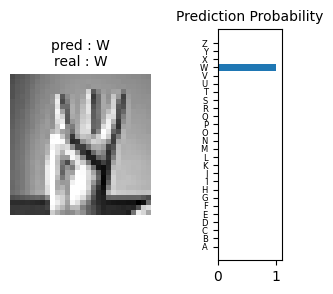

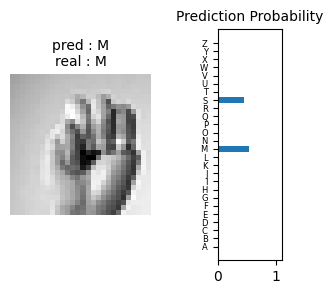

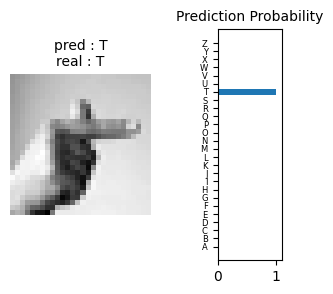

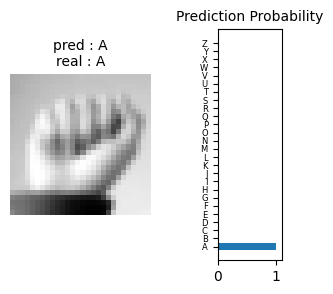

In [51]:
log_pred_prob_batch = sign_fnn(image_batch)
visualize_preds(
    image_batch, label_batch, log_pred_prob_batch, class_names=class_names, start_at=15, num_labels=26, label_size=6
)

#### Effect of scrambling on the FNN 

To test this, a permutatioin will be fixed and the training with be performed using that permutation of pixels

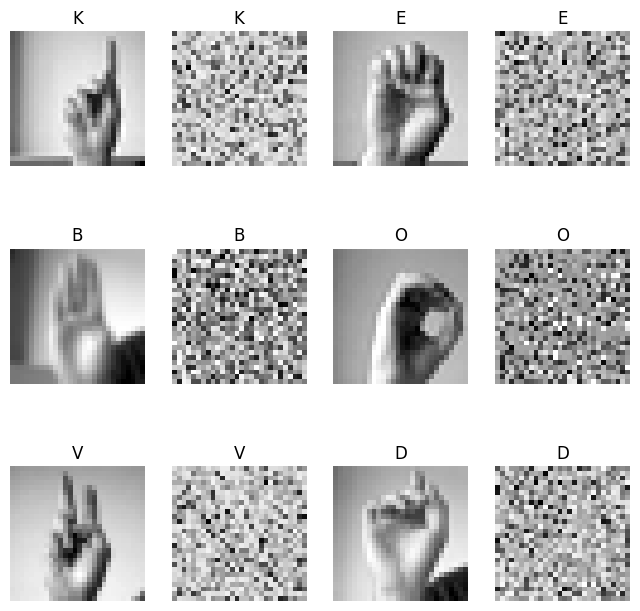

In [52]:


image_batch, label_batch = next(iter(sign_test))
scramble_plt(image_batch, label_batch, fixed_perm, class_names=class_names)

Training the network on scrambled images

In [53]:
print("Training on ", device)
# initializer a network with the same parameters as the normal case
sign_scrambled_fnn = SignFNN(input_size, output_size)
sign_scrambled_fnn.to(device)

optimizer = optim.Adam(sign_scrambled_fnn.parameters(), lr=0.001)
print("Number of parameters: {}".format(get_n_params(sign_scrambled_fnn)))

Training on  cuda:0
Number of parameters: 260126


In [54]:
# Training for 15 epochs, testing after 3 epochs. Also passing the fixed_perm through this function
train_loop(sign_scrambled_fnn, sign_train, sign_test, optimizer, perm=fixed_perm, num_epoch=51, test_interval=5)

Starting training from epoch 0


Training Epoch 0:   0%|          | 0/429 [00:00<?, ?it/s]

Training Epoch 0: 100%|██████████| 429/429 [00:02<00:00, 157.73it/s, loss=1.84, avg_loss=2.49]


Test set: Avg. loss : 2.16	Accuracy : 1828/7172 (25.5%)


Training Epoch 5: 100%|██████████| 429/429 [00:02<00:00, 148.82it/s, loss=0.502, avg_loss=0.542]


Test set: Avg. loss : 1.64	Accuracy : 4272/7172 (59.6%)


Training Epoch 10: 100%|██████████| 429/429 [00:02<00:00, 167.37it/s, loss=0.0899, avg_loss=0.162]


Test set: Avg. loss : 1.81	Accuracy : 4982/7172 (69.5%)


Training Epoch 15: 100%|██████████| 429/429 [00:02<00:00, 147.48it/s, loss=0.0237, avg_loss=0.0913] 


Test set: Avg. loss : 1.96	Accuracy : 4982/7172 (69.5%)


Training Epoch 20: 100%|██████████| 429/429 [00:02<00:00, 152.68it/s, loss=0.115, avg_loss=0.142]   


Test set: Avg. loss : 1.94	Accuracy : 5177/7172 (72.2%)


Training Epoch 25: 100%|██████████| 429/429 [00:02<00:00, 158.13it/s, loss=0.00159, avg_loss=0.0668] 


Test set: Avg. loss : 1.94	Accuracy : 5254/7172 (73.3%)


Training Epoch 30: 100%|██████████| 429/429 [00:02<00:00, 152.21it/s, loss=0.000632, avg_loss=0.00144]


Test set: Avg. loss : 1.99	Accuracy : 5177/7172 (72.2%)


Training Epoch 35: 100%|██████████| 429/429 [00:02<00:00, 145.40it/s, loss=0.18, avg_loss=0.0418]     


Test set: Avg. loss : 1.78	Accuracy : 4765/7172 (66.4%)


Training Epoch 40: 100%|██████████| 429/429 [00:02<00:00, 145.65it/s, loss=0.0136, avg_loss=0.00208]   


Test set: Avg. loss : 2.25	Accuracy : 5034/7172 (70.2%)


Training Epoch 45: 100%|██████████| 429/429 [00:02<00:00, 151.83it/s, loss=0.000205, avg_loss=0.000308]


Test set: Avg. loss : 2.19	Accuracy : 5228/7172 (72.9%)


Training Epoch 50: 100%|██████████| 429/429 [00:02<00:00, 149.14it/s, loss=3.02e-5, avg_loss=0.000108] 


Test set: Avg. loss : 2.47	Accuracy : 5234/7172 (73.0%)
Training for 50 epochs completed!


[25.488008923591746,
 59.56497490239821,
 69.46458449525934,
 69.46458449525934,
 72.18349135527049,
 73.25711098717234,
 72.18349135527049,
 66.43892916899051,
 70.18962632459565,
 72.89459007250419,
 72.97824874511991]

The accuracy seems to be 73%, which is very close to the standard FCNN

Testing the model output by passing scrambled images

In [55]:
sign_scrambled_fnn.to('cpu')

# get a batch of image and label, then scramble the images
image_batch, label_batch = next(iter(sign_test))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)

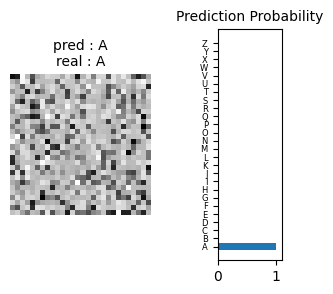

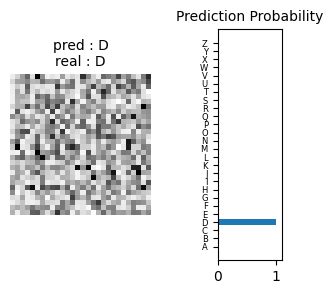

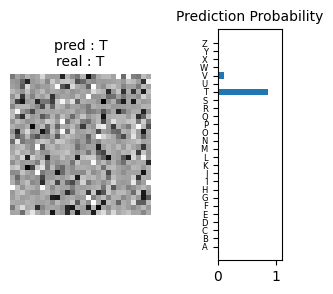

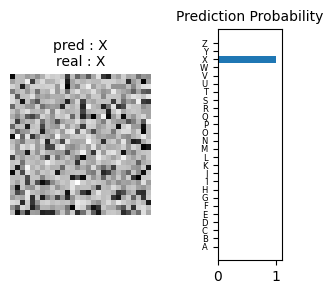

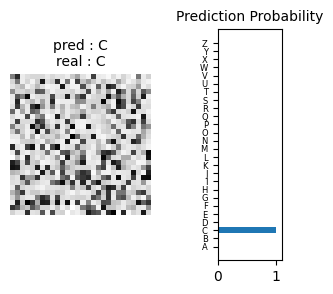

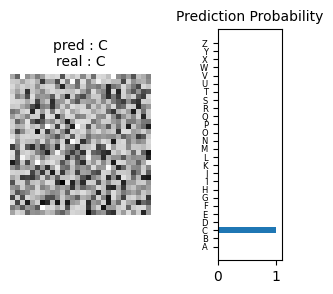

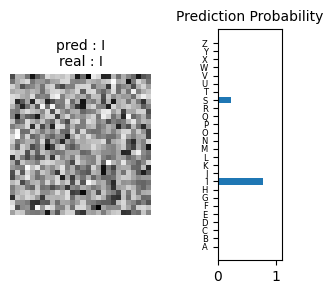

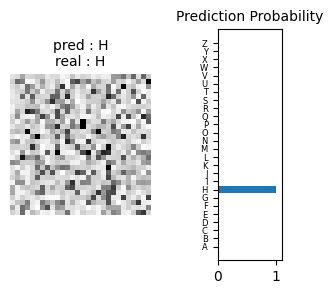

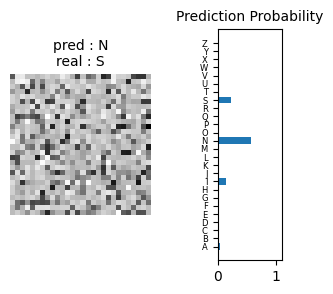

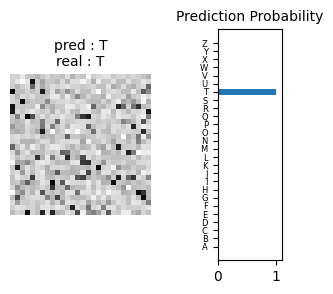

In [56]:
# get the log probs for the labels predicted by the scrambled model on the scrambled batch
log_pred_prob_batch = sign_scrambled_fnn(image_batch_scramble)
visualize_preds(
    image_batch_scramble, label_batch, log_pred_prob_batch, class_names=class_names, start_at=10,num_labels=26, label_size=6
)

#### Adversarial attack on SignMNIST FNN using FGSM method
We will fix some values of epsilon and see the accuracy of the model after an FGSM attack with that epsilon is conducted on that model

In [57]:
epsilons = [0, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]

adv_examples = []  # store examples for eachepsilon
adv_accs = []      # store the accuracy for each epsilon

In [58]:
# run the attack for each epsilon
for eps in epsilons:
    acc, adv_exs = fgsm_test(sign_fnn, sign_test, eps)
    adv_examples.append(adv_exs)
    adv_accs.append(acc)

FGSM attack:   0%|          | 0/7172 [00:00<?, ?it/s]

FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 986.47it/s, Correct : 5332] 


Epsilon: 0	 Test accuracy = 5332/7172 = 0.743446737311768


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 978.25it/s, Correct : 5114] 


Epsilon: 0.001	 Test accuracy = 5114/7172 = 0.7130507529280535


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 959.79it/s, Correct : 4882] 


Epsilon: 0.002	 Test accuracy = 4882/7172 = 0.6807027328499721


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 984.77it/s, Correct : 4430] 


Epsilon: 0.004	 Test accuracy = 4430/7172 = 0.6176798661461238


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 1014.78it/s, Correct : 3460]


Epsilon: 0.008	 Test accuracy = 3460/7172 = 0.48243167875069715


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 973.18it/s, Correct : 3053] 


Epsilon: 0.01	 Test accuracy = 3053/7172 = 0.42568321249302843


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 981.95it/s, Correct : 1660] 


Epsilon: 0.02	 Test accuracy = 1660/7172 = 0.23145566090351366


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 982.51it/s, Correct : 577] 


Epsilon: 0.04	 Test accuracy = 577/7172 = 0.08045175683212492


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 977.77it/s, Correct : 150] 


Epsilon: 0.08	 Test accuracy = 150/7172 = 0.02091466815393196


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 999.51it/s, Correct : 122] 


Epsilon: 0.1	 Test accuracy = 122/7172 = 0.01701059676519799


FGSM attack: 100%|██████████| 7172/7172 [00:07<00:00, 972.71it/s, Correct : 38] 


Epsilon: 0.2	 Test accuracy = 38/7172 = 0.005298382598996096


The epsilon-accuracy graph 

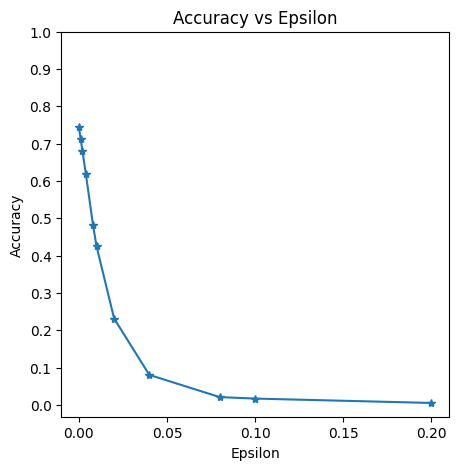

In [59]:
plot_eps_vs_acc(epsilons, adv_accs)

Some examples of successful misclassifications for each epsilon value

/tmp/ipykernel_24507/3767312654.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=figsize, ncols=4)


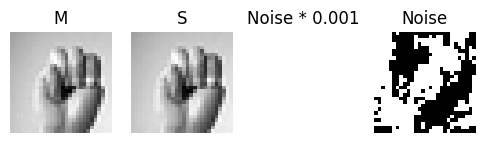

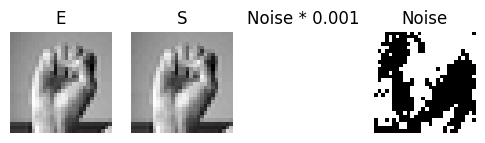

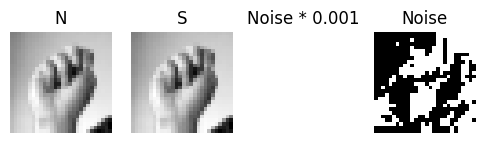

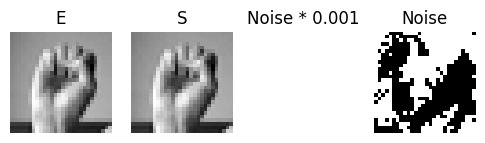

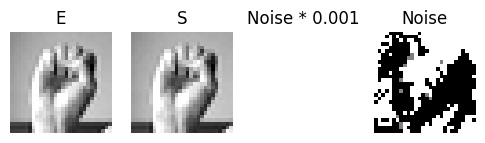

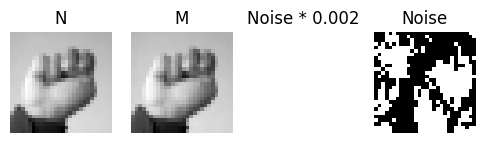

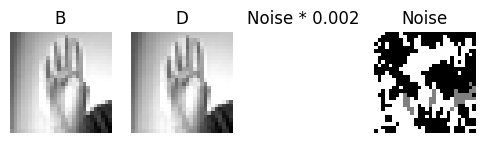

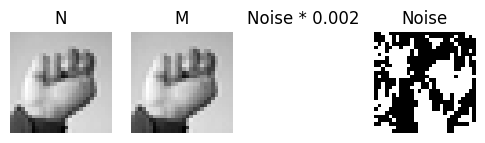

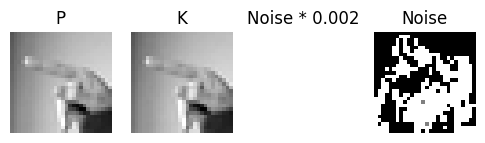

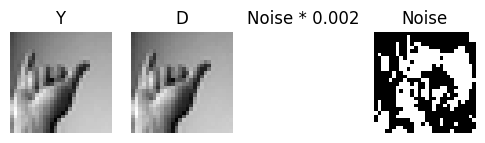

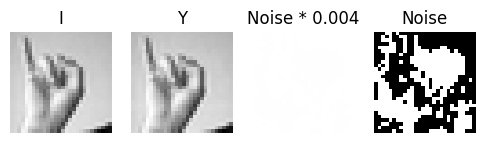

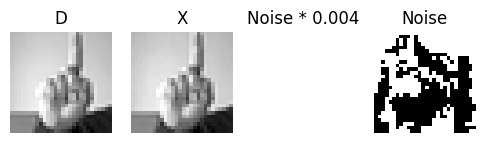

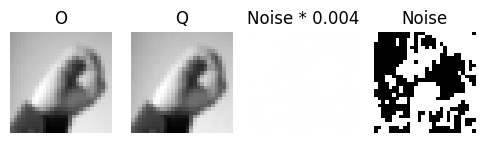

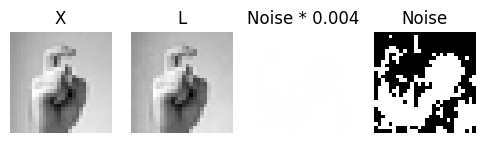

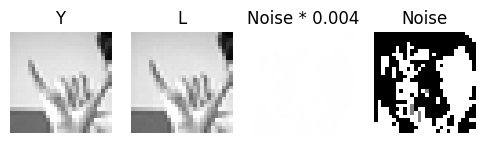

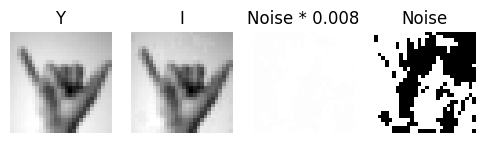

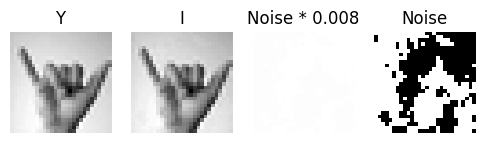

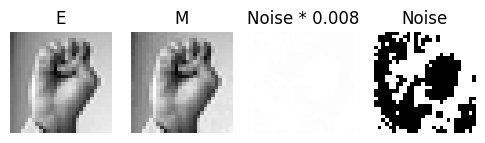

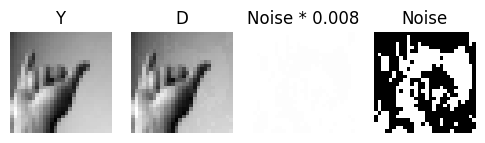

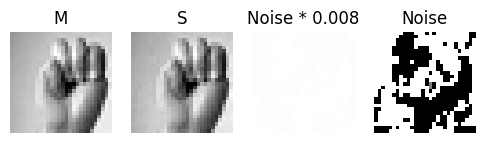

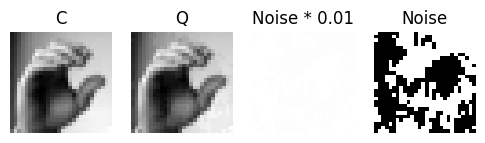

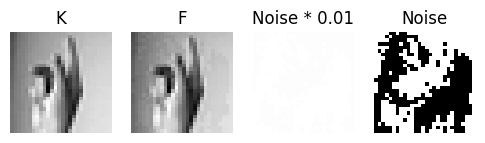

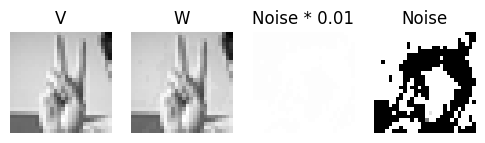

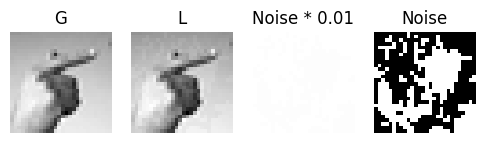

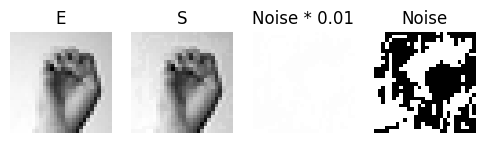

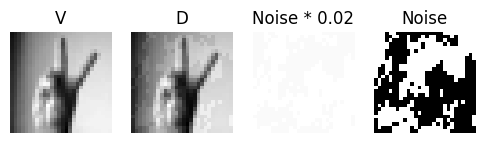

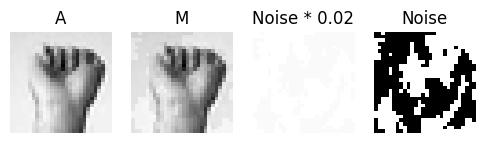

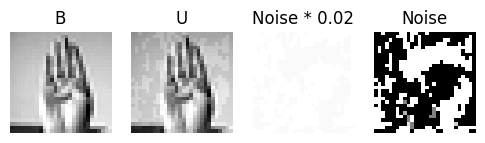

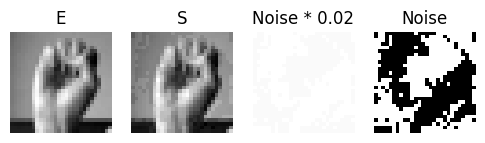

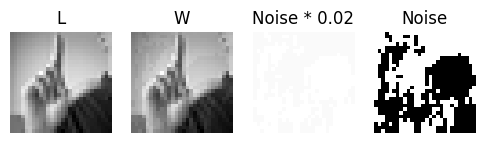

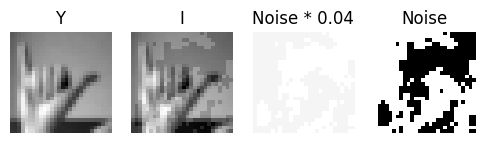

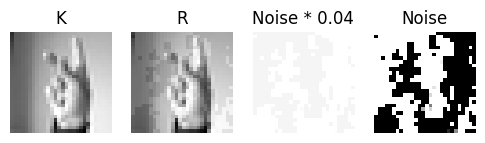

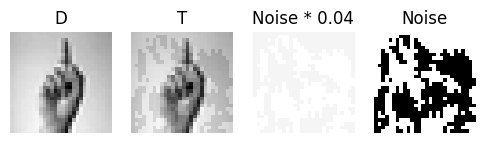

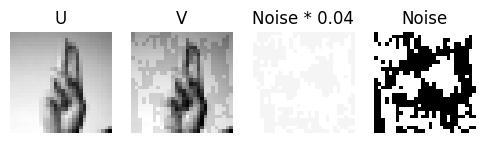

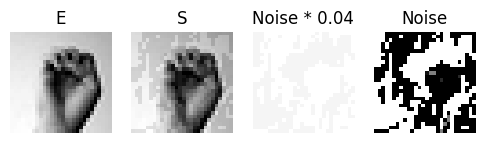

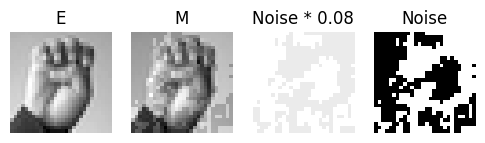

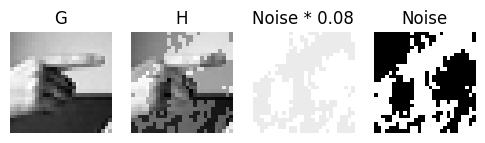

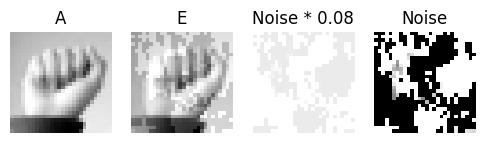

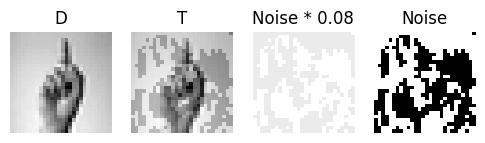

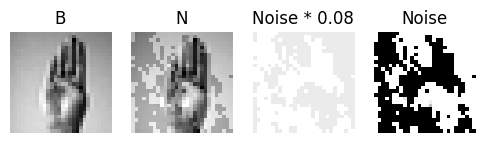

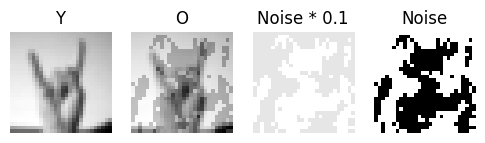

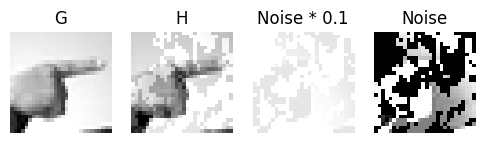

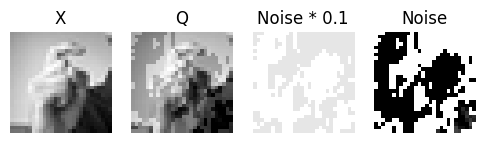

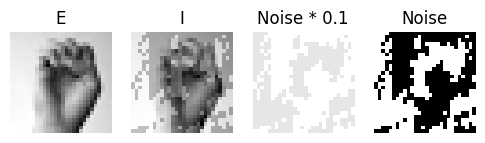

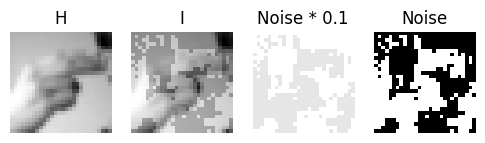

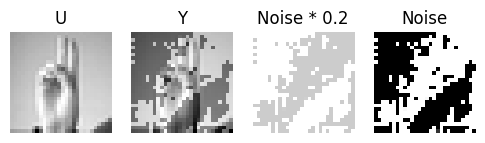

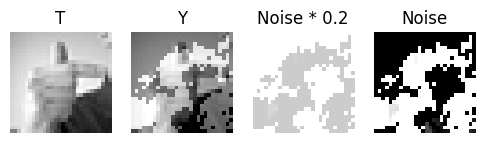

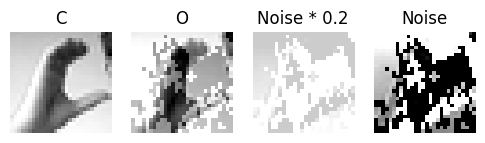

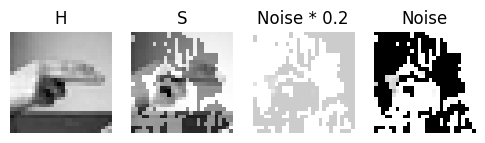

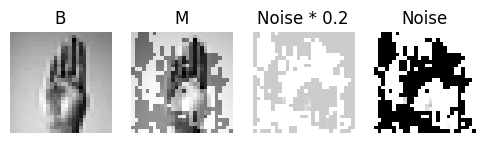

In [60]:
for i in range(len(epsilons)):
    for j in range(min(5, len(adv_examples[i]))): 
        show_fgsm_example(epsilons[i], adv_examples[i][j], class_names = class_names)

The best value of epsilon seems to be between 0.02 and 0.04

### Convolution Network for SignMNIST

The network used here consists of 3 convolution layer, kernel sizes 3, 5, 5 respectively. The first two conv layers are followed by relu and a 2x2 maxpool. This is followed by a flatten operation and then a fully connected network with one hidden layer with 200 neurons. At the end there is a logsoftmax 

In [61]:
class SignCNN(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(SignCNN, self).__init__()
        self.conv_netowrk = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
        )

        self.fc_network = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_netowrk(x)
        x = x.view(-1, 128*4*4)
        x = self.fc_network(x)
        return x

In [62]:
print("Training on ", device)

# initializing the network
sign_cnn = SignCNN(input_size, output_size)
sign_cnn.to(device)

# Using the Adam optimizer with 0.004 learning rate
optimizer = optim.Adam(sign_cnn.parameters(), lr=0.001)
print(f"Number of parameters: {get_n_params(sign_cnn)}")

Training on  cuda:0
Number of parameters: 1155546


In [63]:
# Training for 15 epochs, testing after 3 epochs
train_loop(sign_cnn, sign_train, sign_test, optimizer, num_epoch=22, test_interval=3)

Starting training from epoch 0


Training Epoch 0: 100%|██████████| 429/429 [00:03<00:00, 123.96it/s, loss=0.0115, avg_loss=0.127]  


Test set: Avg. loss : 0.51	Accuracy : 6134/7172 (85.5%)


Training Epoch 3: 100%|██████████| 429/429 [00:03<00:00, 121.17it/s, loss=1.72e-5, avg_loss=4.3e-5]  


Test set: Avg. loss : 0.20	Accuracy : 6868/7172 (95.8%)


Training Epoch 6: 100%|██████████| 429/429 [00:03<00:00, 118.01it/s, loss=9.08e-6, avg_loss=1.54e-5]


Test set: Avg. loss : 0.20	Accuracy : 6874/7172 (95.8%)


Training Epoch 9: 100%|██████████| 429/429 [00:03<00:00, 116.66it/s, loss=3.75e-6, avg_loss=7.5e-6] 


Test set: Avg. loss : 0.19	Accuracy : 6873/7172 (95.8%)


Training Epoch 12: 100%|██████████| 429/429 [00:03<00:00, 123.79it/s, loss=1.26e-6, avg_loss=3.55e-6]


Test set: Avg. loss : 0.20	Accuracy : 6878/7172 (95.9%)


Training Epoch 15: 100%|██████████| 429/429 [00:03<00:00, 126.96it/s, loss=2.03e-6, avg_loss=1.88e-6]


Test set: Avg. loss : 0.20	Accuracy : 6879/7172 (95.9%)


Training Epoch 18: 100%|██████████| 429/429 [00:03<00:00, 112.89it/s, loss=3.39e-7, avg_loss=1.01e-6]


Test set: Avg. loss : 0.20	Accuracy : 6878/7172 (95.9%)


Training Epoch 21: 100%|██████████| 429/429 [00:03<00:00, 135.64it/s, loss=3.07e-7, avg_loss=5.35e-7]


Test set: Avg. loss : 0.21	Accuracy : 6881/7172 (95.9%)
Training for 21 epochs completed!


[85.52704963747908,
 95.76129392080313,
 95.84495259341885,
 95.83100948131623,
 95.90072504182933,
 95.91466815393196,
 95.90072504182933,
 95.9425543781372]

Looking at some results

In [64]:
sign_cnn.to("cpu").eval()
image_batch, label_batch = next(iter(sign_test))

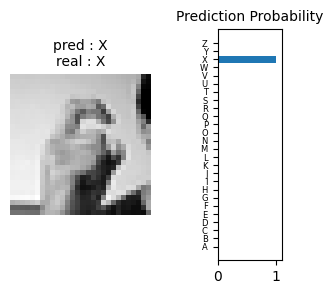

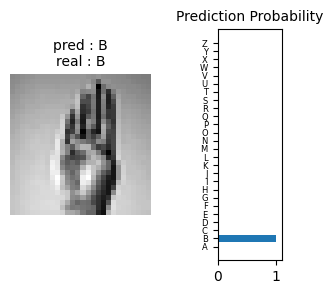

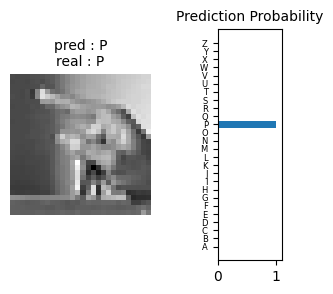

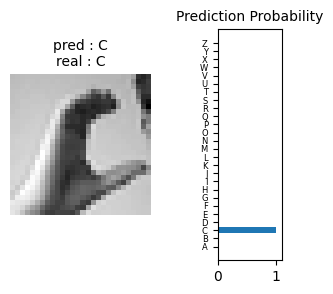

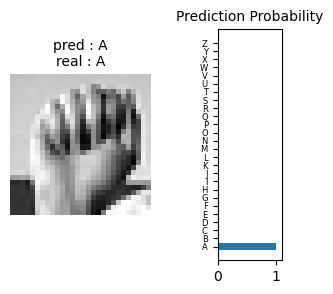

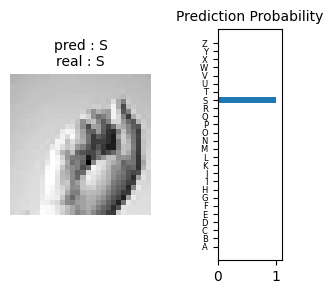

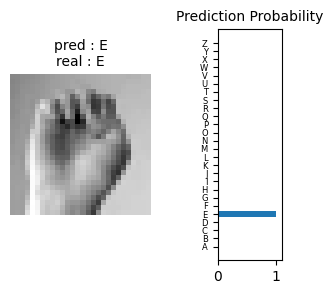

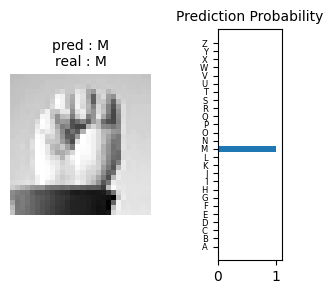

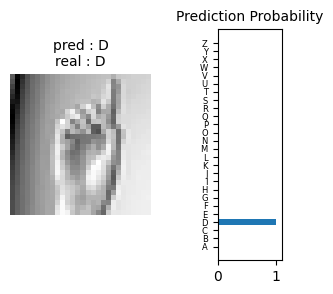

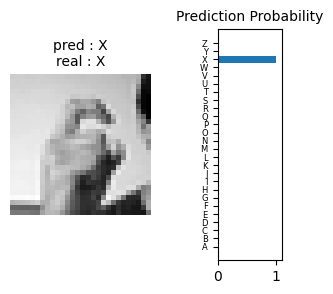

In [65]:
log_pred_prob_batch = sign_cnn(image_batch)
visualize_preds(
    image_batch, label_batch, log_pred_prob_batch, class_names=class_names, start_at=15, num_labels=26, label_size=6
)

#### Effect of scrambling on the CNN 

To test this, a permutatioin will be fixed and the training with be performed using that permutation of pixels

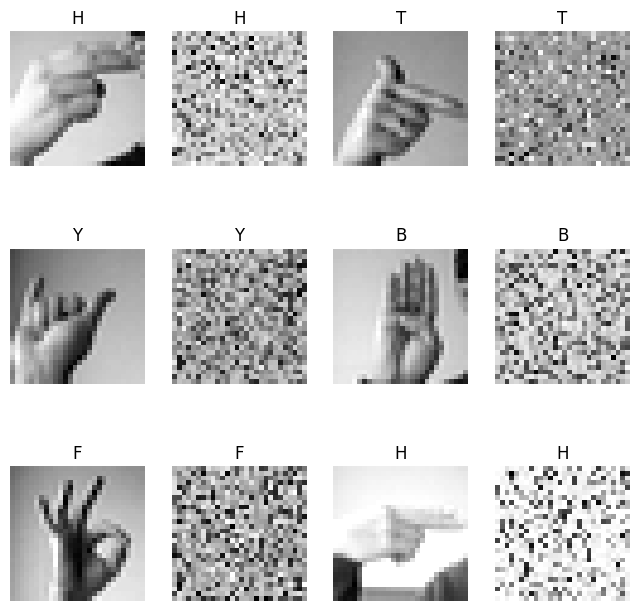

In [66]:


image_batch, label_batch = next(iter(sign_test))
scramble_plt(image_batch, label_batch, fixed_perm, class_names=class_names)

Training the network on scrambled images

In [67]:
print("Training on ", device)
# initializer a network with the same parameters as the normal case
sign_scrambled_cnn = SignCNN(input_size, output_size)
sign_scrambled_cnn.to(device)

optimizer = optim.Adam(sign_scrambled_cnn.parameters(), lr=0.001)
print("Number of parameters: {}".format(get_n_params(sign_scrambled_cnn)))

Training on  cuda:0
Number of parameters: 1155546


In [68]:
# Training for 15 epochs, testing after 3 epochs. Also passing the fixed_perm through this function
train_loop(sign_scrambled_cnn, sign_train, sign_test, optimizer, perm=fixed_perm, num_epoch=22, test_interval=3)

Starting training from epoch 0


Training Epoch 0:   0%|          | 0/429 [00:00<?, ?it/s]

Training Epoch 0: 100%|██████████| 429/429 [00:03<00:00, 127.12it/s, loss=0.0012, avg_loss=0.209]  


Test set: Avg. loss : 0.88	Accuracy : 5617/7172 (78.3%)


Training Epoch 3: 100%|██████████| 429/429 [00:03<00:00, 121.91it/s, loss=8.69e-5, avg_loss=9.44e-5]  


Test set: Avg. loss : 0.98	Accuracy : 5612/7172 (78.2%)


Training Epoch 6: 100%|██████████| 429/429 [00:03<00:00, 119.15it/s, loss=2.32e-5, avg_loss=2.7e-5] 


Test set: Avg. loss : 1.04	Accuracy : 5631/7172 (78.5%)


Training Epoch 9: 100%|██████████| 429/429 [00:03<00:00, 122.74it/s, loss=7.21e-6, avg_loss=1.07e-5]


Test set: Avg. loss : 1.09	Accuracy : 5621/7172 (78.4%)


Training Epoch 12: 100%|██████████| 429/429 [00:03<00:00, 123.32it/s, loss=3.02e-6, avg_loss=4.72e-6]


Test set: Avg. loss : 1.15	Accuracy : 5644/7172 (78.7%)


Training Epoch 15: 100%|██████████| 429/429 [00:03<00:00, 118.71it/s, loss=1.05e-6, avg_loss=2.23e-6]


Test set: Avg. loss : 1.19	Accuracy : 5656/7172 (78.9%)


Training Epoch 18: 100%|██████████| 429/429 [00:03<00:00, 124.97it/s, loss=1.01e-6, avg_loss=1.06e-6]


Test set: Avg. loss : 1.24	Accuracy : 5654/7172 (78.8%)


Training Epoch 21: 100%|██████████| 429/429 [00:03<00:00, 131.04it/s, loss=4.65e-7, avg_loss=5.27e-7]


Test set: Avg. loss : 1.28	Accuracy : 5647/7172 (78.7%)
Training for 21 epochs completed!


[78.31846068042387,
 78.24874511991077,
 78.51366424986057,
 78.37423312883436,
 78.69492470719464,
 78.8622420524261,
 78.83435582822086,
 78.73675404350251]

Testing the model output by passing scrambled images

In [69]:
sign_scrambled_cnn.to('cpu')

# get a batch of image and label, then scramble the images
image_batch, label_batch = next(iter(sign_test))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)

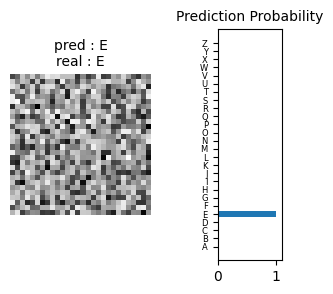

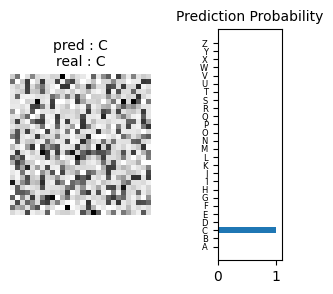

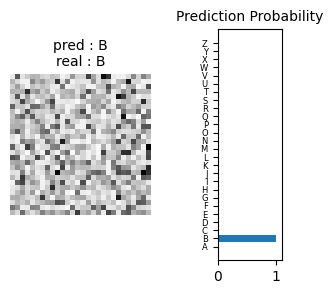

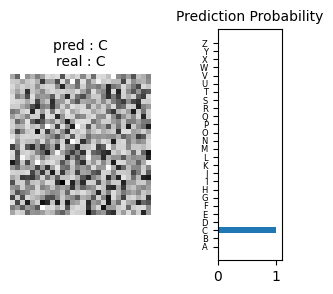

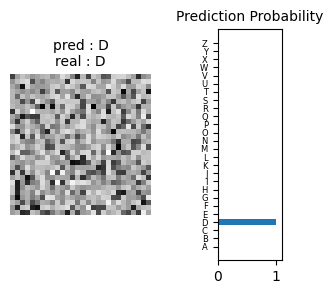

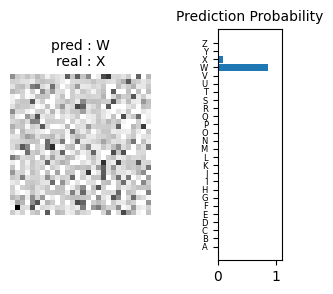

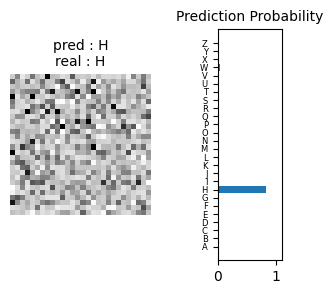

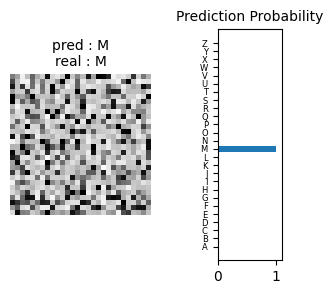

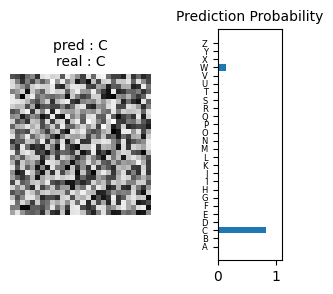

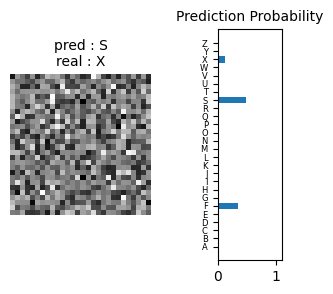

In [70]:
# get the log probs for the labels predicted by the scrambled model on the scrambled batch
log_pred_prob_batch = sign_scrambled_cnn(image_batch_scramble)
visualize_preds(
    image_batch_scramble, label_batch, log_pred_prob_batch, class_names=class_names, num_labels=26, label_size=6
)

#### Adversarial attack on SignMNIST CNN using FGSM method
We will fix some values of epsilon and see the accuracy of the model after an FGSM attack with that epsilon is conducted on that model

In [71]:
epsilons = [0, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]

adv_examples = []  # store examples for eachepsilon
adv_accs = []      # store the accuracy for each epsilon

In [72]:
# run the attack for each epsilon
for eps in epsilons:
    acc, adv_exs = fgsm_test(sign_cnn, sign_test, eps)
    adv_examples.append(adv_exs)
    adv_accs.append(acc)

FGSM attack:   0%|          | 0/7172 [00:00<?, ?it/s]

FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 589.77it/s, Correct : 6881]


Epsilon: 0	 Test accuracy = 6881/7172 = 0.959425543781372


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 585.42it/s, Correct : 6798]


Epsilon: 0.001	 Test accuracy = 6798/7172 = 0.9478527607361963


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 589.47it/s, Correct : 6635]


Epsilon: 0.002	 Test accuracy = 6635/7172 = 0.9251254880089236


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 590.72it/s, Correct : 6313]


Epsilon: 0.004	 Test accuracy = 6313/7172 = 0.880228667038483


FGSM attack: 100%|██████████| 7172/7172 [00:11<00:00, 601.16it/s, Correct : 5570]


Epsilon: 0.008	 Test accuracy = 5570/7172 = 0.7766313441160066


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 555.45it/s, Correct : 5186]


Epsilon: 0.01	 Test accuracy = 5186/7172 = 0.7230897936419409


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 593.35it/s, Correct : 3414]


Epsilon: 0.02	 Test accuracy = 3414/7172 = 0.4760178471834914


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 581.55it/s, Correct : 2066]


Epsilon: 0.04	 Test accuracy = 2066/7172 = 0.28806469604015617


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 588.97it/s, Correct : 1201]


Epsilon: 0.08	 Test accuracy = 1201/7172 = 0.16745677635248188


FGSM attack: 100%|██████████| 7172/7172 [00:11<00:00, 606.90it/s, Correct : 1055]


Epsilon: 0.1	 Test accuracy = 1055/7172 = 0.14709983268265478


FGSM attack: 100%|██████████| 7172/7172 [00:12<00:00, 594.87it/s, Correct : 693]

Epsilon: 0.2	 Test accuracy = 693/7172 = 0.09662576687116564


The epsilon-accuracy graph 

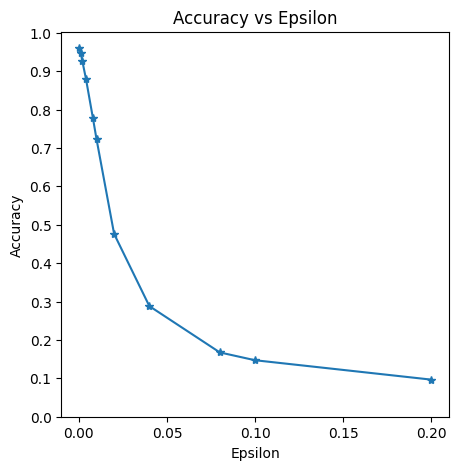

In [73]:
plot_eps_vs_acc(epsilons, adv_accs)

Some examples of successful misclassifications for each epsilon value

/tmp/ipykernel_24507/3767312654.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=figsize, ncols=4)


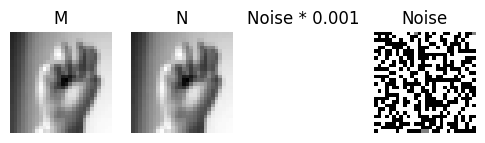

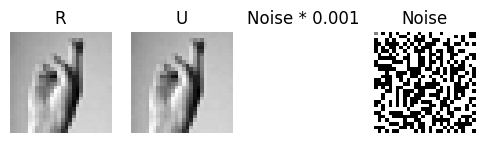

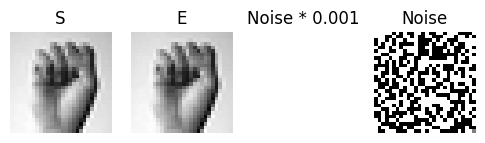

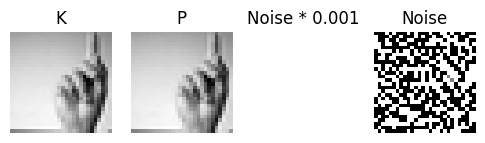

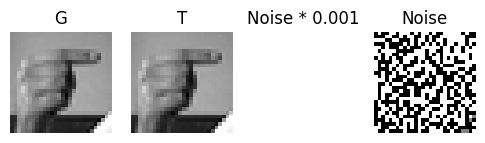

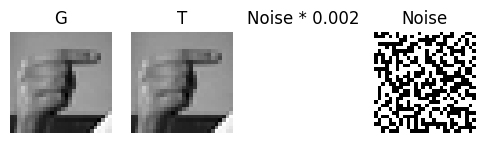

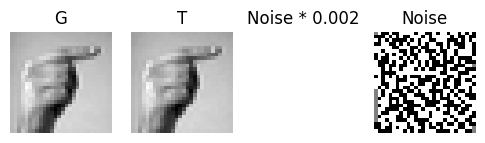

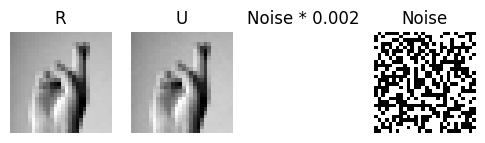

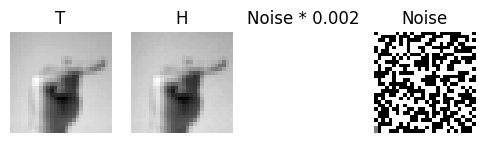

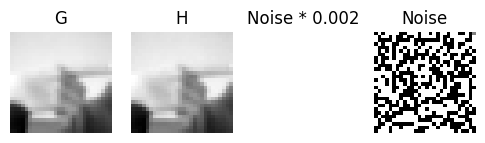

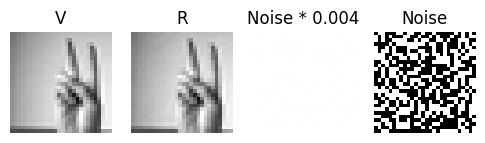

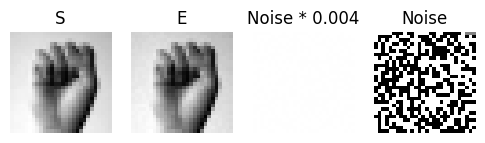

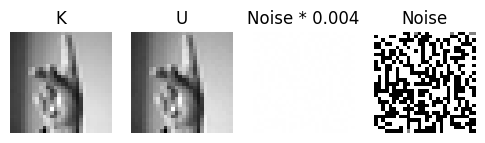

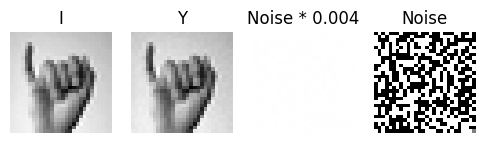

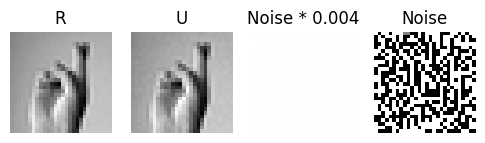

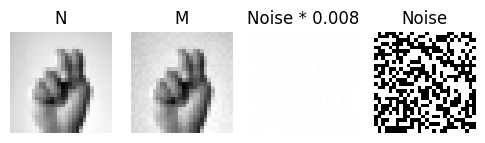

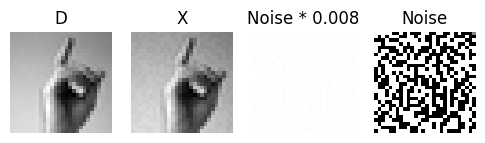

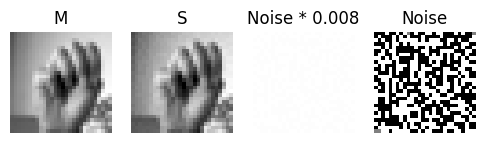

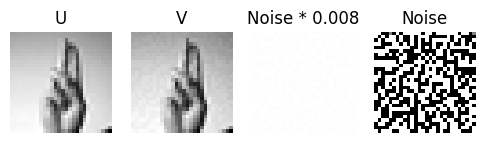

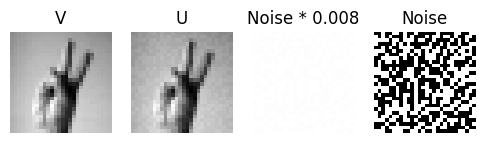

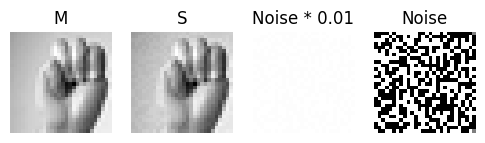

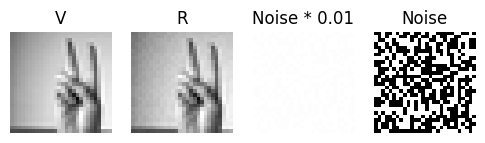

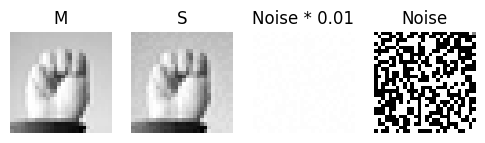

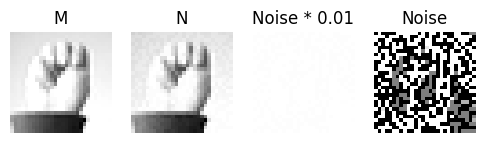

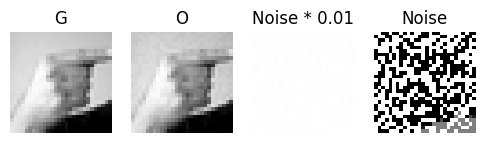

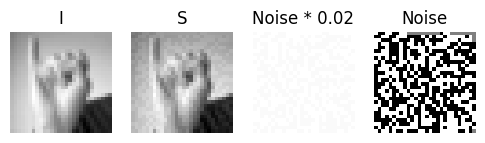

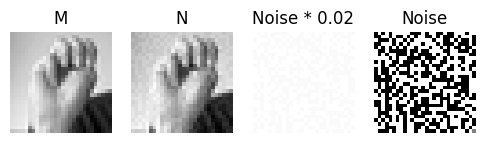

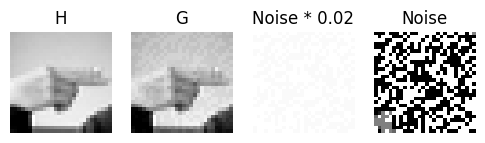

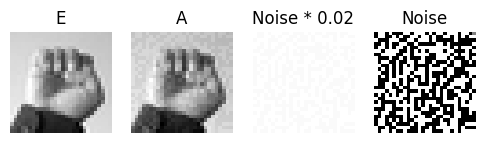

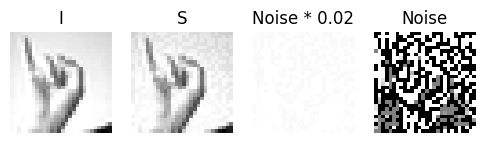

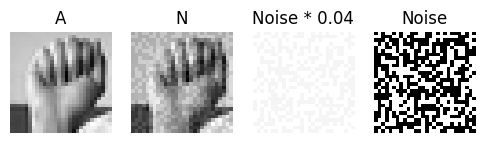

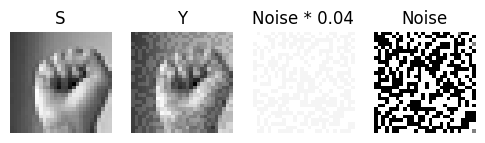

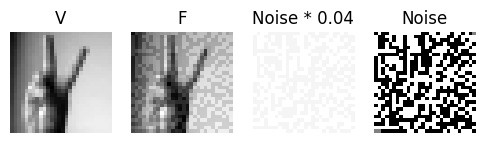

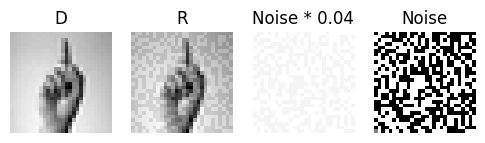

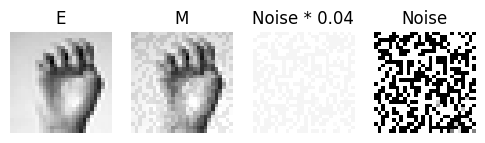

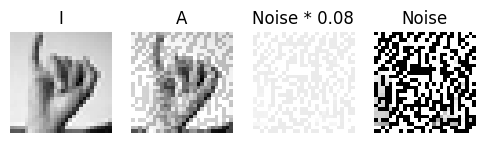

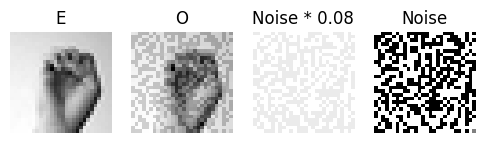

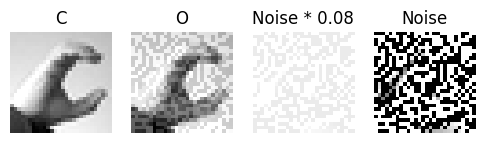

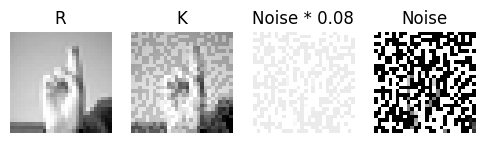

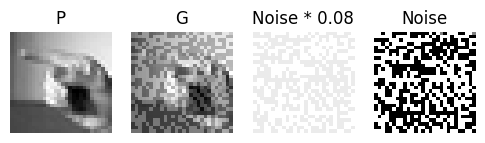

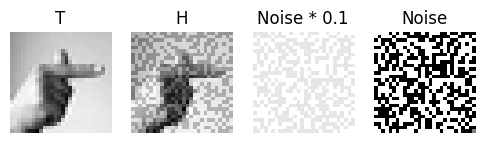

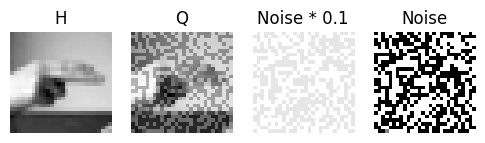

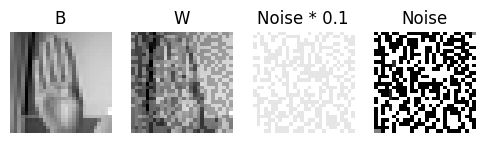

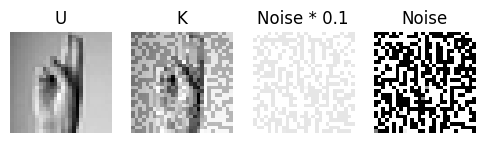

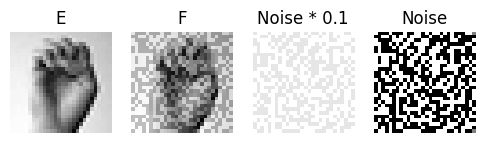

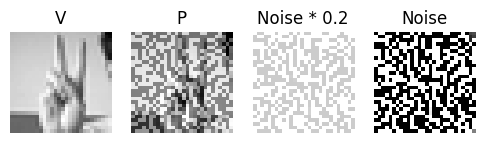

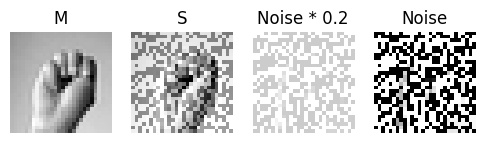

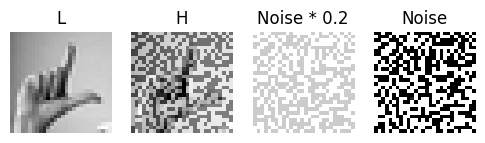

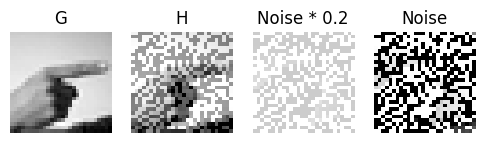

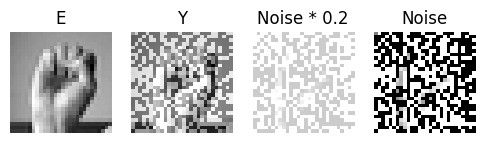

In [74]:
for i in range(len(epsilons)):
    for j in range(min(5, len(adv_examples[i]))): 
        show_fgsm_example(epsilons[i], adv_examples[i][j], class_names = class_names)